|  🎯 **Model**                       |  🔍 **Test Loss**  | ⏱ **Inference (ms/img)**  |  📊 **Params (Million)**     |  📈 **Train Epoches Required** | 
| :----------------------------------: | :----------: | :-------------------: | :--------------------: | :-----------------------: |
| Simple UNet (ResNet-34)  | 0.0115          | 6.08           | 24.44                    | 33                  |
| DeepLabV3+ (ResNet-18)   | 0.0095          | 4.94       | 12.33                    | **21**                   |   
| DeepLabV3+ (MobileNetV2) | **0.0086**      | 6.58                   | 4.38                    | 24                |
| Unet (Efficientnet-b0)   | 0.0089          | 12.90                   | 6.30                    | 34                         |                          
| **Axial-UNet** (experimental)| 0.0147          | 7.19                   | 20.65                    | 44                         |
| **MobileViT-UNet** (experimental)| 0.0125               | 7.74                   | 11.89                    |        52                 |
| **MobileViT-UNet Lite** (experimental)| 0.0183               | **3.79**                   | **2.89**                    |        61                 |
          

---
## **Some Results** 

|  🎯 **Model**                    |  🔍 **Result**  | 
| :------------------------: | :----------: | 
| Simple UNet (ResNet-34)  | 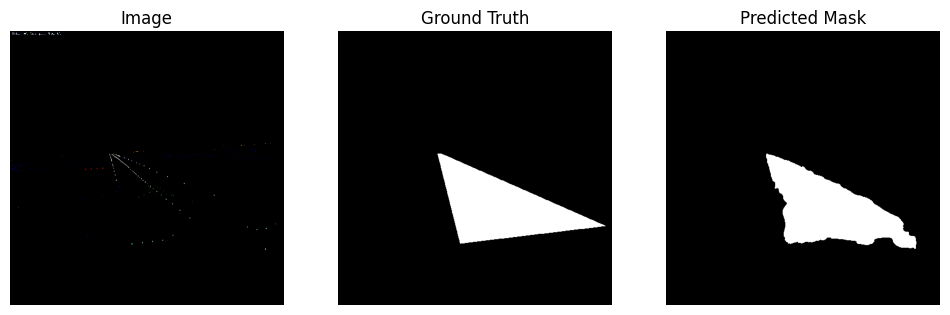          |
| DeepLabV3+ (ResNet-18)   | 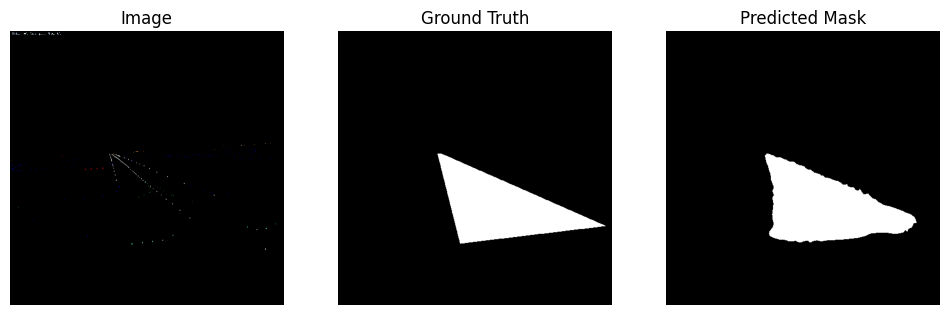          |
| DeepLabV3+ (MobileNetV2) | 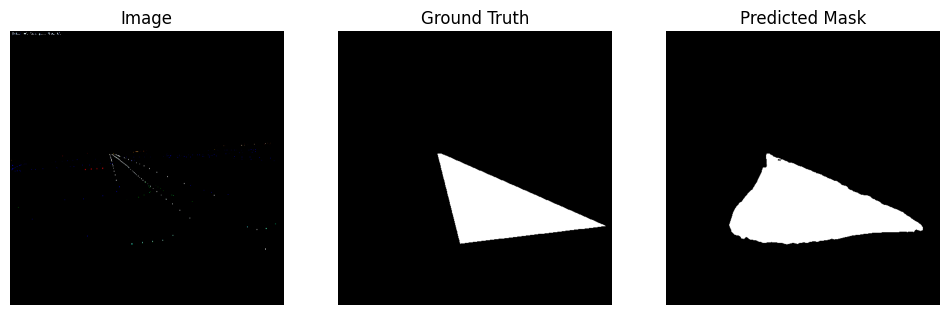          |
| Unet (Efficientnet-b0)   | 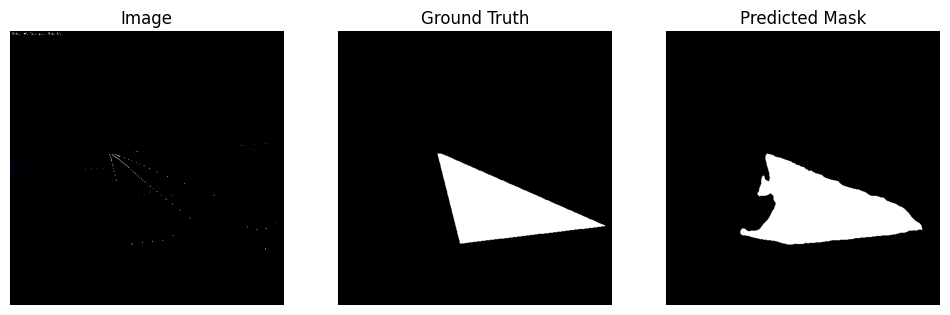          |
| **Axial-UNet** (experimental)| 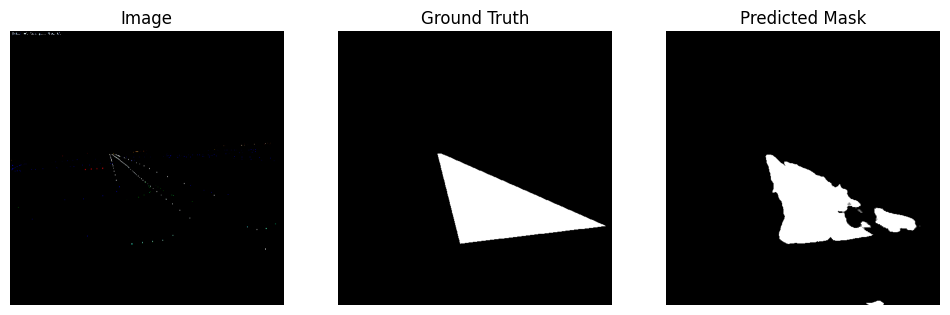      |
| **MobileViT-UNet Lite** (experimental)| 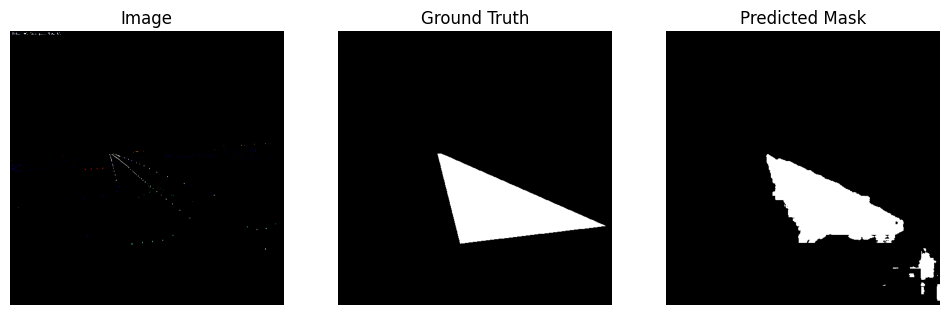  |
          
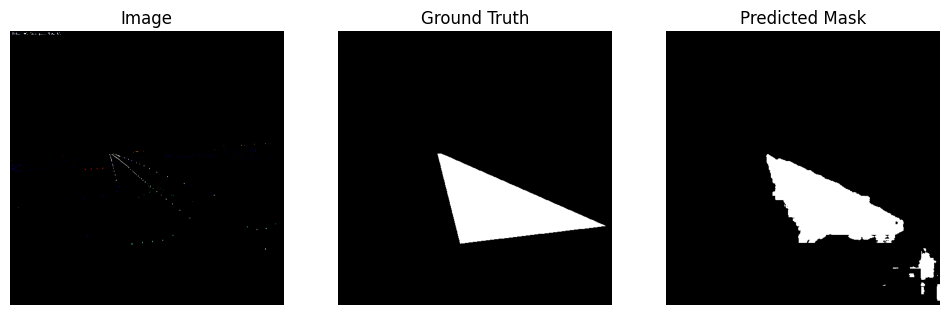
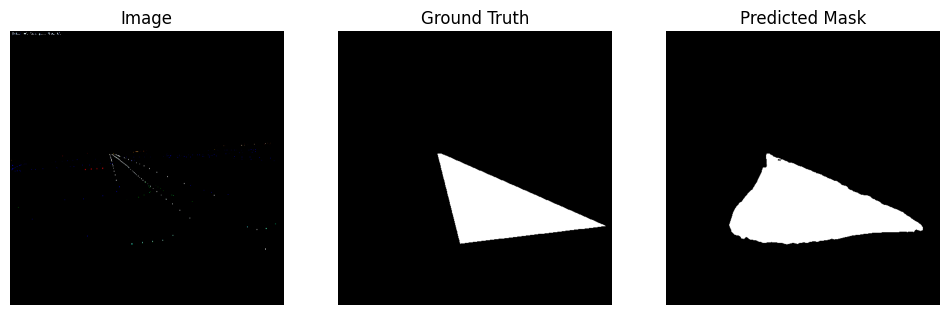
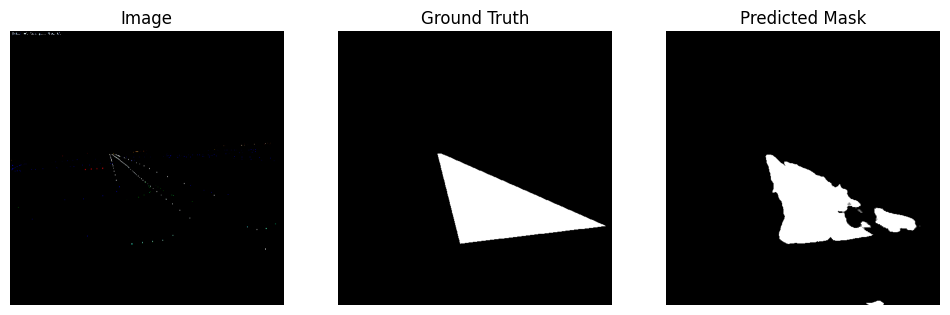
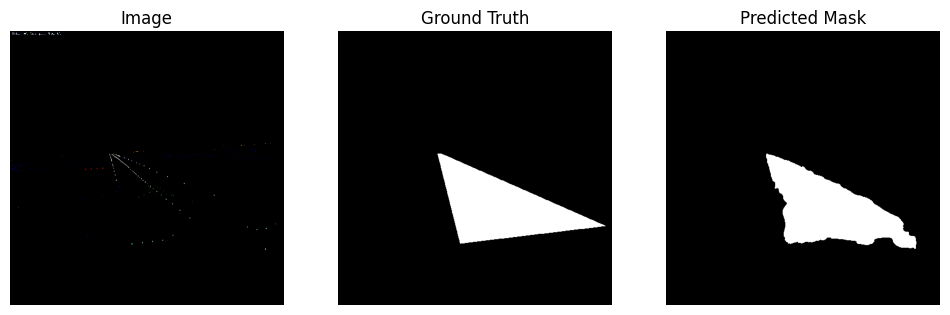
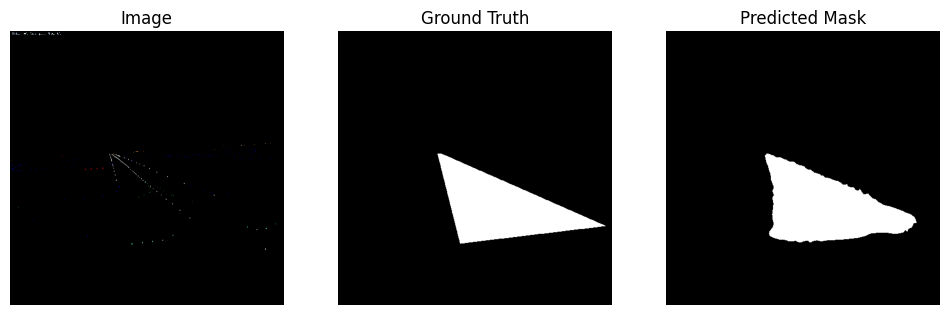
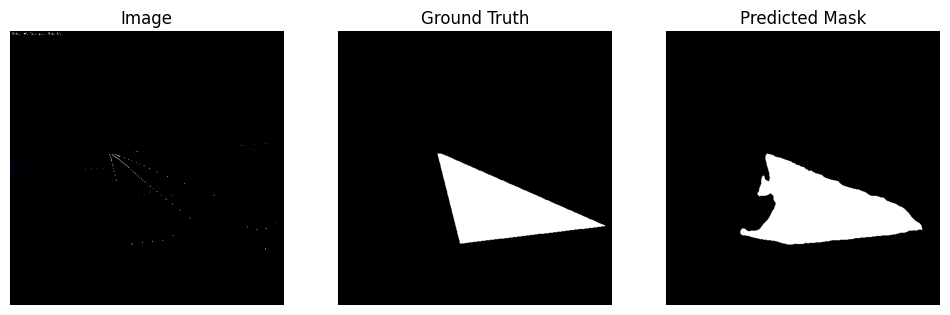

---

In [1]:
import os
import cv2
import json
import torch
import random
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

2025-06-26 13:10:18.487645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750943418.510891     868 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750943418.518220     868 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
images_dir ='/kaggle/input/fs2020-runway-dataset/1920x1080/1920x1080/train'
outputs_dir = '/kaggle/input/fs2020-runway-dataset/labels/labels/areas/train_labels_1920x1080'

In [3]:
images_list = os.listdir(images_dir)
outputs_list = os.listdir(outputs_dir)
some_images = np.random.choice(images_list, size = 9, replace = False)

In [4]:
len(images_list)

3987

In [5]:
len(outputs_list)

3987

In [6]:
from dataclasses import dataclass, field

@dataclass
class Config:
    IMG_LIST = images_list
    OUT_LIST = outputs_list
    LEARNING_RATE: float = 1e-3
    BATCH_SIZE: int = 8
    DEVICE: str = field(default_factory=lambda: "cuda" if torch.cuda.is_available() else "cpu")
    MODEL_SAVE_PATH: str = "/kaggle/working"
    BASE_DIR: str = '/kaggle/input/coco-2017-dataset/coco2017'
    IDLE_DEVICE: str = 'cpu'
    IMG_SIZE = 512
    INPUT_SIZE = (512, 512)


config = Config()

In [7]:
image_size=512
input_image_size=(512,512)

In [8]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (config.IMG_SIZE, config.IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

## INPUT

In [ ]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(some_images):
        img = read_image(f"{images_dir}/{some_images[i]}")
        ax.set_title(f"{some_images[i]}")
        ax.imshow(img)
        ax.axis('off')

## Expected Outputs

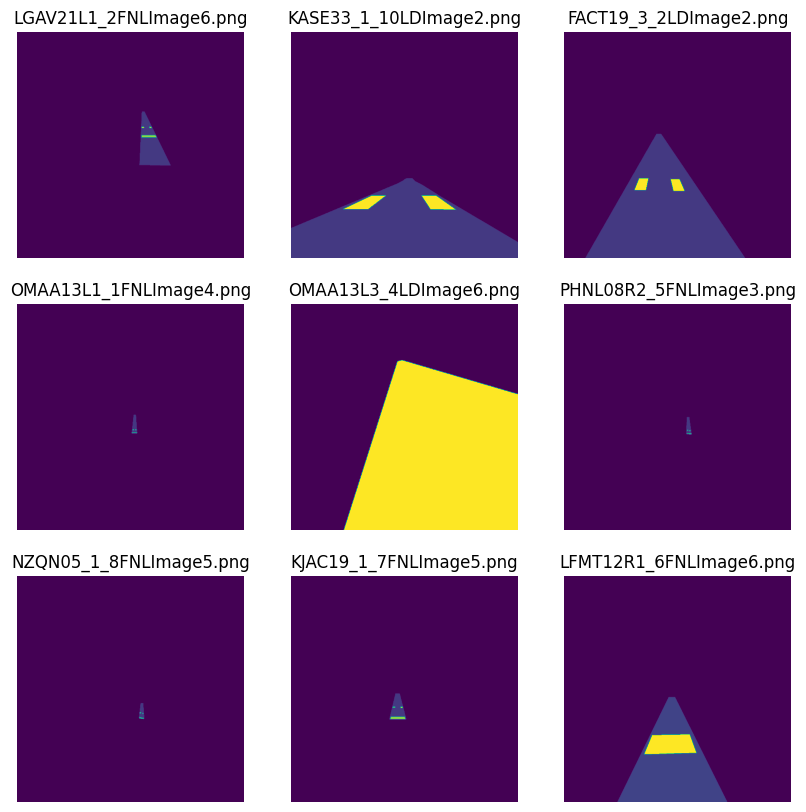

In [10]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(some_images):
        file=some_images[i]
        if os.path.exists(os.path.join(outputs_dir,file)):
            img = read_image(f"{outputs_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{some_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

### Dataset Loader 

In [11]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms

class RunwaySegmentationDataset(Dataset):
    def __init__(self, image_paths, output_paths, image_size=512, transform=None):
        self.image_paths = image_paths
        self.output_paths = output_paths
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = cv2.imread(self.image_paths[idx])
        image = cv2.resize(image, (self.image_size, self.image_size))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        # Load outputs
        out = cv2.imread(self.output_paths[idx], cv2.IMREAD_GRAYSCALE)
        out = cv2.resize(out, (self.image_size, self.image_size))
        out = (out > 0).astype(np.float32)  # binary out (0 or 1)

        if self.transform:
            image = self.transform(image)

        out = torch.tensor(out).unsqueeze(0)        # HW to 1xHxW

        return image, out


In [12]:
all_images = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir)])
all_outputs = sorted([os.path.join(outputs_dir, f) for f in os.listdir(outputs_dir) if os.path.exists(os.path.join(outputs_dir, f))])

# Ensure image-output pairs match
valid_pairs = [(img, out) for img, out in zip(all_images, all_outputs) if os.path.exists(out)]

# Optional: limit to first 500 samples
valid_pairs = valid_pairs[:]

image_paths, output_paths = zip(*valid_pairs)

image_train, image_test, output_train, output_test = train_test_split(
    image_paths, output_paths, test_size=0.3, random_state=33)

In [13]:
image_transforms = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = RunwaySegmentationDataset(image_train, output_train, transform=image_transforms)
test_dataset = RunwaySegmentationDataset(image_test, output_test, transform=image_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)


In [14]:
for images, outputs in train_loader:
    print("Image batch shape:", images.shape)
    print("Output batch shape:", outputs.shape)
    break

Image batch shape: torch.Size([8, 3, 512, 512])
Output batch shape: torch.Size([8, 1, 512, 512])


In [15]:
!pip install segmentation-models-pytorch opencv-python  --quiet

## Standard Unet Model 

In [75]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None, 
)
model = model.to(config.DEVICE)

In [41]:
sum(p.numel() for p in model.parameters())

24436369

In [25]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

criterion = nn.BCEWithLogitsLoss()  # loss function that combines a sigmoid activation and the binary cross-entropy (BCE) loss in a single function best for binary classification
optimizer = optim.Adam(model.parameters(), lr=5e-4)
ACCUMULATION_STEPS = 2

def train_epoch(loader):
    model.train()
    running_loss = 0
    optimizer.zero_grad()

    loop = tqdm(enumerate(loader), total=len(loader), desc=f"Train Epoch {epoch}")
    for step, (imgs, lbls) in loop:
        imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
        preds = model(imgs)
        loss = criterion(preds, lbls) / ACCUMULATION_STEPS  # scale loss

        loss.backward()
        running_loss += loss.item() * ACCUMULATION_STEPS  # un‐scale for logging

        # gradient step once every ACCUMULATION_STEPS
        if (step + 1) % ACCUMULATION_STEPS == 0 or (step + 1) == len(loader):
            optimizer.step()
            optimizer.zero_grad()

        loop.set_postfix({
            "batch_loss": f"{running_loss / (step + 1):.4f}"
        })

    avg_loss = running_loss / len(loader)
    return avg_loss



def eval_epoch(loader, epoch):
    model.eval()
    running_loss = 0.0

    loop = tqdm(enumerate(loader), total=len(loader), desc=f"Eval  Epoch {epoch}", colour="green")
    with torch.no_grad():
        for step, (imgs, lbls) in loop:
            imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
            preds = model(imgs)
            loss = criterion(preds, lbls)

            running_loss += loss.item()
            loop.set_postfix({
                "batch_loss": f"{running_loss / (step + 1):.4f}"
            })

    avg_loss = running_loss / len(loader)
    return avg_loss

In [ ]:
EPOCHS = 50

for epoch in range(21, EPOCHS + 1):
    train_loss = train_epoch(train_loader)
    val_loss = eval_epoch(test_loader, epoch)
    print(f"Epoch {epoch}/{EPOCHS} — train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")

    # Save model
    torch.save(model.state_dict(), f"unet_epoch{epoch}.pth")


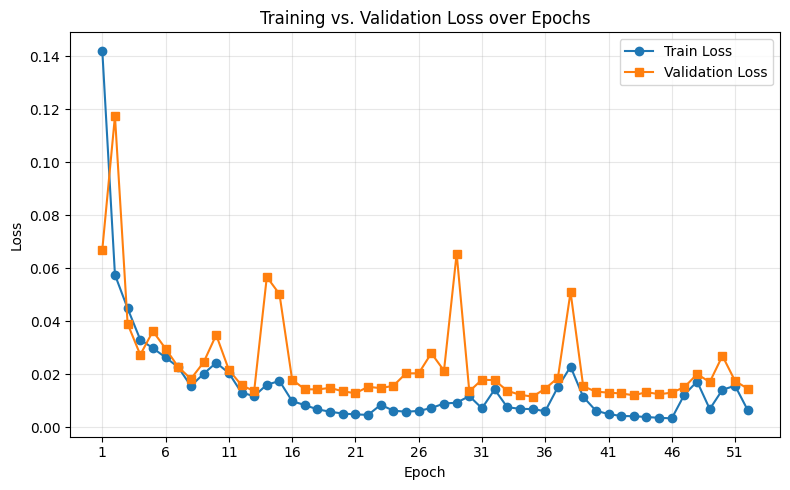
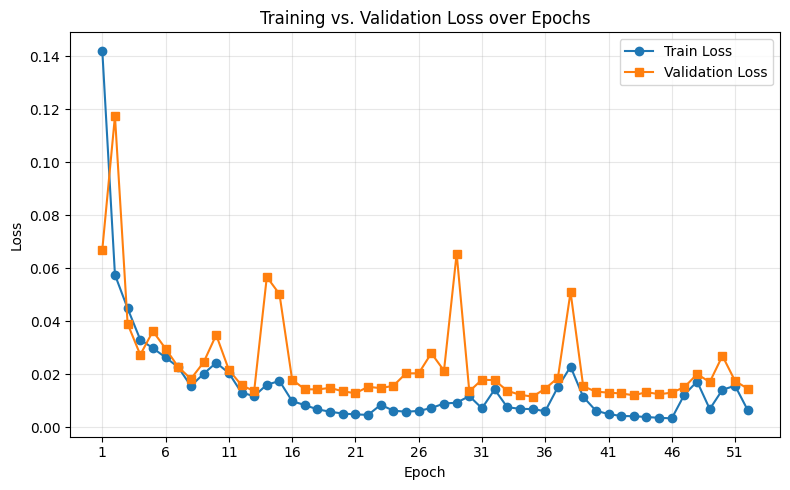

### *BEST Result* <br/>  **Epoch 33: train_loss = 0.0068, val_loss = 0.0115**

In [ ]:
import matplotlib.pyplot as plt

# Replace these lists with your actual loss values in order
train_loss = [
    0.1421, 0.0575, 0.0448, 0.0330, 0.0298, 0.0263, 0.0226, 0.0155, 0.0201, 0.0243,
    0.0204, 0.0130, 0.0117, 0.0160, 0.0174, 0.0098, 0.0083, 0.0067, 0.0058, 0.0051,
    0.0048, 0.0046, 0.0084, 0.0062, 0.0058, 0.0061, 0.0072, 0.0089, 0.0092, 0.0117,
    0.0071, 0.0142, 0.0075, 0.0069, 0.0068, 0.0060, 0.0151, 0.0228, 0.0114, 0.0062,
    0.0049, 0.0042, 0.0041, 0.0038, 0.0035, 0.0033, 0.0123, 0.0172, 0.0068, 0.0141,
    0.0156, 0.0064
]

val_loss = [
    0.0670, 0.1174, 0.0390, 0.0273, 0.0362, 0.0296, 0.0227, 0.0182, 0.0244, 0.0348,
    0.0216, 0.0158, 0.0136, 0.0567, 0.0502, 0.0179, 0.0143, 0.0142, 0.0148, 0.0135,
    0.0128, 0.0152, 0.0147, 0.0156, 0.0203, 0.0203, 0.0279, 0.0213, 0.0655, 0.0135,
    0.0179, 0.0177, 0.0137, 0.0122, 0.0115, 0.0145, 0.0186, 0.0510, 0.0154, 0.0134,
    0.0130, 0.0127, 0.0120, 0.0132, 0.0124, 0.0130, 0.0151, 0.0200, 0.0170, 0.0269,
    0.0174, 0.0145
]

epochs = list(range(1, len(train_loss) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss,   marker='s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss over Epochs')
plt.xticks(epochs[::5])        # show every 5th epoch on the x-axis
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
Train Epoch 1: 100%|██████████| 88/88 [01:31<00:00,  1.04s/it, batch_loss=0.1421]
Eval  Epoch 1: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s, batch_loss=0.0670]
Epoch 1/20 — train_loss: 0.1421, val_loss: 0.0670
Train Epoch 2: 100%|██████████| 88/88 [01:29<00:00,  1.01s/it, batch_loss=0.0575]
Eval  Epoch 2: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s, batch_loss=0.1174]
Epoch 2/20 — train_loss: 0.0575, val_loss: 0.1174
Train Epoch 1: 100%|██████████| 88/88 [01:29<00:00,  1.01s/it, batch_loss=0.0448]
Eval  Epoch 1: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0390]
Epoch 1/20 — train_loss: 0.0448, val_loss: 0.0390
Train Epoch 2: 100%|██████████| 88/88 [01:30<00:00,  1.02s/it, batch_loss=0.0330]
Eval  Epoch 2: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0273]
Epoch 2/20 — train_loss: 0.0330, val_loss: 0.0273
Train Epoch 3: 100%|██████████| 88/88 [01:30<00:00,  1.02s/it, batch_loss=0.0298]
Eval  Epoch 3: 100%|██████████| 38/38 [00:34<00:00,  1.10it/s, batch_loss=0.0362]
Epoch 3/20 — train_loss: 0.0298, val_loss: 0.0362
Train Epoch 4: 100%|██████████| 88/88 [01:28<00:00,  1.01s/it, batch_loss=0.0263]
Eval  Epoch 4: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s, batch_loss=0.0296]
Epoch 4/20 — train_loss: 0.0263, val_loss: 0.0296
Train Epoch 5: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it, batch_loss=0.0226]
Eval  Epoch 5: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0227]
Epoch 5/20 — train_loss: 0.0226, val_loss: 0.0227
Train Epoch 6: 100%|██████████| 88/88 [01:30<00:00,  1.03s/it, batch_loss=0.0155]
Eval  Epoch 6: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s, batch_loss=0.0182]
Epoch 6/20 — train_loss: 0.0155, val_loss: 0.0182
Train Epoch 7: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it, batch_loss=0.0201]
Eval  Epoch 7: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0244]
Epoch 7/20 — train_loss: 0.0201, val_loss: 0.0244
Train Epoch 8: 100%|██████████| 88/88 [01:31<00:00,  1.03s/it, batch_loss=0.0243]
Eval  Epoch 8: 100%|██████████| 38/38 [00:35<00:00,  1.06it/s, batch_loss=0.0348]
Epoch 8/20 — train_loss: 0.0243, val_loss: 0.0348
Train Epoch 9: 100%|██████████| 88/88 [01:28<00:00,  1.01s/it, batch_loss=0.0204]
Eval  Epoch 9: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0216]
Epoch 9/20 — train_loss: 0.0204, val_loss: 0.0216
Train Epoch 10: 100%|██████████| 88/88 [01:29<00:00,  1.01s/it, batch_loss=0.0130]
Eval  Epoch 10: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0158]
Epoch 10/20 — train_loss: 0.0130, val_loss: 0.0158
Train Epoch 11: 100%|██████████| 88/88 [01:30<00:00,  1.03s/it, batch_loss=0.0117]
Eval  Epoch 11: 100%|██████████| 38/38 [00:35<00:00,  1.09it/s, batch_loss=0.0136]
Epoch 11/20 — train_loss: 0.0117, val_loss: 0.0136
Train Epoch 12: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it, batch_loss=0.0160]
Eval  Epoch 12: 100%|██████████| 38/38 [00:35<00:00,  1.07it/s, batch_loss=0.0567]
Epoch 12/20 — train_loss: 0.0160, val_loss: 0.0567
Train Epoch 13: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it, batch_loss=0.0174]
Eval  Epoch 13: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0502]
Epoch 13/20 — train_loss: 0.0174, val_loss: 0.0502
Train Epoch 14: 100%|██████████| 88/88 [01:29<00:00,  1.01s/it, batch_loss=0.0098]
Eval  Epoch 14: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s, batch_loss=0.0179]
Epoch 14/20 — train_loss: 0.0098, val_loss: 0.0179
Train Epoch 15: 100%|██████████| 88/88 [01:29<00:00,  1.01s/it, batch_loss=0.0083]
Eval  Epoch 15: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0143]
Epoch 15/20 — train_loss: 0.0083, val_loss: 0.0143
Train Epoch 16: 100%|██████████| 88/88 [01:30<00:00,  1.02s/it, batch_loss=0.0067]
Eval  Epoch 16: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s, batch_loss=0.0142]
Epoch 16/20 — train_loss: 0.0067, val_loss: 0.0142
Train Epoch 17: 100%|██████████| 88/88 [01:28<00:00,  1.01s/it, batch_loss=0.0058]
Eval  Epoch 17: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0148]
Epoch 17/20 — train_loss: 0.0058, val_loss: 0.0148
Train Epoch 18: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it, batch_loss=0.0051]
Eval  Epoch 18: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0135]
Epoch 18/20 — train_loss: 0.0051, val_loss: 0.0135
Train Epoch 19: 100%|██████████| 88/88 [01:30<00:00,  1.03s/it, batch_loss=0.0048]
Eval  Epoch 19: 100%|██████████| 38/38 [00:35<00:00,  1.07it/s, batch_loss=0.0128]
Epoch 19/20 — train_loss: 0.0048, val_loss: 0.0128
Train Epoch 20: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it, batch_loss=0.0046]
Eval  Epoch 20: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s, batch_loss=0.0152]
Epoch 20/20 — train_loss: 0.0046, val_loss: 0.0152
Train Epoch 21: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it, batch_loss=0.0084]
Eval  Epoch 21: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0147]
Epoch 21/50 — train_loss: 0.0084, val_loss: 0.0147
Train Epoch 22: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it, batch_loss=0.0062]
Eval  Epoch 22: 100%|██████████| 38/38 [00:35<00:00,  1.06it/s, batch_loss=0.0156]
Epoch 22/50 — train_loss: 0.0062, val_loss: 0.0156
Train Epoch 23: 100%|██████████| 88/88 [01:30<00:00,  1.03s/it, batch_loss=0.0058]
Eval  Epoch 23: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s, batch_loss=0.0203]
Epoch 23/50 — train_loss: 0.0058, val_loss: 0.0203
Train Epoch 24: 100%|██████████| 88/88 [01:28<00:00,  1.00s/it, batch_loss=0.0061]
Eval  Epoch 24: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s, batch_loss=0.0203]
Epoch 24/50 — train_loss: 0.0061, val_loss: 0.0203
Train Epoch 25: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it, batch_loss=0.0072]
Eval  Epoch 25: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s, batch_loss=0.0279]
Epoch 25/50 — train_loss: 0.0072, val_loss: 0.0279
Train Epoch 26: 100%|██████████| 88/88 [01:28<00:00,  1.01s/it, batch_loss=0.0089]
Eval  Epoch 26: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s, batch_loss=0.0213]
Epoch 26/50 — train_loss: 0.0089, val_loss: 0.0213
Train Epoch 27: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it, batch_loss=0.0092]
Eval  Epoch 27: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s, batch_loss=0.0655]
Epoch 27/50 — train_loss: 0.0092, val_loss: 0.0655
Train Epoch 28: 100%|██████████| 88/88 [01:30<00:00,  1.03s/it, batch_loss=0.0117]
Eval  Epoch 28: 100%|██████████| 38/38 [00:34<00:00,  1.10it/s, batch_loss=0.0135]
Epoch 28/50 — train_loss: 0.0117, val_loss: 0.0135
Train Epoch 29: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it, batch_loss=0.0071]
Eval  Epoch 29: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s, batch_loss=0.0179]
Epoch 29/50 — train_loss: 0.0071, val_loss: 0.0179
Train Epoch 30: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it, batch_loss=0.0142]
Eval  Epoch 30: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0177]
Epoch 30/50 — train_loss: 0.0142, val_loss: 0.0177
Train Epoch 31: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it, batch_loss=0.0075]
Eval  Epoch 31: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0137]
Epoch 31/50 — train_loss: 0.0075, val_loss: 0.0137
Train Epoch 32: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it, batch_loss=0.0069]
Eval  Epoch 32: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0122]
Epoch 32/50 — train_loss: 0.0069, val_loss: 0.0122
Train Epoch 33: 100%|██████████| 88/88 [01:31<00:00,  1.03s/it, batch_loss=0.0068]
Eval  Epoch 33: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0115]
Epoch 33/50 — train_loss: 0.0068, val_loss: 0.0115
Train Epoch 34: 100%|██████████| 88/88 [01:31<00:00,  1.04s/it, batch_loss=0.0060]
Eval  Epoch 34: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0145]
Epoch 34/50 — train_loss: 0.0060, val_loss: 0.0145
Train Epoch 35: 100%|██████████| 88/88 [01:31<00:00,  1.04s/it, batch_loss=0.0151]
Eval  Epoch 35: 100%|██████████| 38/38 [00:35<00:00,  1.07it/s, batch_loss=0.0186]
Epoch 35/50 — train_loss: 0.0151, val_loss: 0.0186
Train Epoch 36: 100%|██████████| 88/88 [01:31<00:00,  1.04s/it, batch_loss=0.0228]
Eval  Epoch 36: 100%|██████████| 38/38 [00:35<00:00,  1.07it/s, batch_loss=0.0510]
Epoch 36/50 — train_loss: 0.0228, val_loss: 0.0510
Train Epoch 37: 100%|██████████| 88/88 [01:30<00:00,  1.03s/it, batch_loss=0.0114]
Eval  Epoch 37: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0154]
Epoch 37/50 — train_loss: 0.0114, val_loss: 0.0154
Train Epoch 38: 100%|██████████| 88/88 [01:30<00:00,  1.03s/it, batch_loss=0.0062]
Eval  Epoch 38: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s, batch_loss=0.0134]
Epoch 38/50 — train_loss: 0.0062, val_loss: 0.0134
Train Epoch 39: 100%|██████████| 88/88 [01:30<00:00,  1.03s/it, batch_loss=0.0049]
Eval  Epoch 39: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s, batch_loss=0.0130]
Epoch 39/50 — train_loss: 0.0049, val_loss: 0.0130
Train Epoch 40: 100%|██████████| 88/88 [01:29<00:00,  1.01s/it, batch_loss=0.0042]
Eval  Epoch 40: 100%|██████████| 38/38 [00:35<00:00,  1.07it/s, batch_loss=0.0127]
Epoch 40/50 — train_loss: 0.0042, val_loss: 0.0127
Train Epoch 41: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it, batch_loss=0.0041]
Eval  Epoch 41: 100%|██████████| 38/38 [00:35<00:00,  1.07it/s, batch_loss=0.0120]
Epoch 41/50 — train_loss: 0.0041, val_loss: 0.0120
Train Epoch 42: 100%|██████████| 88/88 [01:30<00:00,  1.03s/it, batch_loss=0.0038]
Eval  Epoch 42: 100%|██████████| 38/38 [00:35<00:00,  1.07it/s, batch_loss=0.0132]
Epoch 42/50 — train_loss: 0.0038, val_loss: 0.0132
Train Epoch 43: 100%|██████████| 88/88 [01:30<00:00,  1.03s/it, batch_loss=0.0035]
Eval  Epoch 43: 100%|██████████| 38/38 [00:35<00:00,  1.06it/s, batch_loss=0.0124]
Epoch 43/50 — train_loss: 0.0035, val_loss: 0.0124
Train Epoch 44: 100%|██████████| 88/88 [01:31<00:00,  1.05s/it, batch_loss=0.0033]
Eval  Epoch 44: 100%|██████████| 38/38 [00:35<00:00,  1.07it/s, batch_loss=0.0130]
Epoch 44/50 — train_loss: 0.0033, val_loss: 0.0130
Train Epoch 45: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it, batch_loss=0.0123]
Eval  Epoch 45: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s, batch_loss=0.0151]
Epoch 45/50 — train_loss: 0.0123, val_loss: 0.0151
Train Epoch 46: 100%|██████████| 88/88 [01:30<00:00,  1.02s/it, batch_loss=0.0172]
Eval  Epoch 46: 100%|██████████| 38/38 [00:35<00:00,  1.07it/s, batch_loss=0.0200]
Epoch 46/50 — train_loss: 0.0172, val_loss: 0.0200
Train Epoch 47: 100%|██████████| 88/88 [01:30<00:00,  1.03s/it, batch_loss=0.0068]
Eval  Epoch 47: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0170]
Epoch 47/50 — train_loss: 0.0068, val_loss: 0.0170
Train Epoch 48: 100%|██████████| 88/88 [01:30<00:00,  1.02s/it, batch_loss=0.0141]
Eval  Epoch 48: 100%|██████████| 38/38 [00:34<00:00,  1.10it/s, batch_loss=0.0269]
Epoch 48/50 — train_loss: 0.0141, val_loss: 0.0269
Train Epoch 49: 100%|██████████| 88/88 [01:30<00:00,  1.03s/it, batch_loss=0.0156]
Eval  Epoch 49: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0174]
Epoch 49/50 — train_loss: 0.0156, val_loss: 0.0174
Train Epoch 50: 100%|██████████| 88/88 [01:29<00:00,  1.02s/it, batch_loss=0.0064]
Eval  Epoch 50: 100%|██████████| 38/38 [00:35<00:00,  1.08it/s, batch_loss=0.0145]
Epoch 50/50 — train_loss: 0.0064, val_loss: 0.0145

In [76]:
def load_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE)
    model.load_state_dict(checkpoint)
    print(f"Checkpoint loaded. Resuming training from epoch {33}")
    
load_checkpoint(model, '/kaggle/working/unet_epoch33.pth')

Checkpoint loaded. Resuming training from epoch 33


In [43]:
# Clear cache
torch.cuda.empty_cache()

### Some Predictions

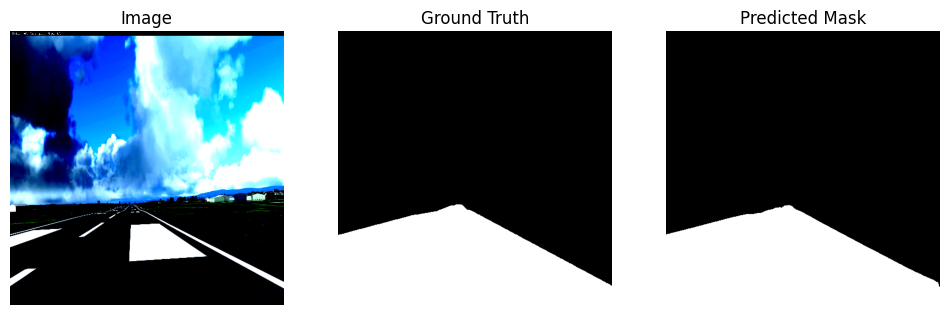

In [77]:
model.eval()
with torch.no_grad():
    imgs, lbls = next(iter(test_loader))
    imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
    preds = model(imgs).cpu()
    preds = torch.sigmoid(preds) > 0.5


img = imgs[5].cpu().permute(1, 2, 0).numpy()
lbl = lbls[5, 0].cpu().numpy()
pred = preds[5, 0].cpu().numpy()

# Visualize 
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(131); plt.imshow(img); plt.title("Image"); plt.axis('off')
plt.subplot(132); plt.imshow(lbl, cmap='gray'); plt.title("Ground Truth"); plt.axis('off')
plt.subplot(133); plt.imshow(pred, cmap='gray'); plt.title("Predicted Mask"); plt.axis('off')
plt.show()


In [36]:
import torch
import time

# 1) Move model to device and set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# 2) Prepare a dummy input (or one real batch) of the right size
#    e.g. batch_size=1, 3×H×W
dummy_input = torch.randn(1, 3, 256, 256, device=device)

# 3) Warm-up (launch a few passes to stabilize the GPU)
with torch.no_grad():
    for _ in range(10):
        _ = model(dummy_input)

# 4) Actual timing with torch.cuda.Event
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

# Number of repeats to average over
n_runs = 100  
times = []

with torch.no_grad():
    for _ in range(n_runs):
        starter.record()           # start timing
        _ = model(dummy_input)     # inference
        ender.record()             # end timing
        # wait for GPU op to finish
        torch.cuda.synchronize()   
        times.append(starter.elapsed_time(ender))  # milliseconds

avg_ms = sum(times) / len(times)
print(f"Avg GPU inference time over {n_runs} runs: {avg_ms:.2f} ms")

# If you want throughput per second:
print(f"≈ {1000/avg_ms:.1f} images/sec")


Avg GPU inference time over 100 runs: 6.08 ms
≈ 164.5 images/sec


---
### **Inference TIME with simple U Net = 6.08ms with Validation Loss = 0.0115 in 33 epoches** 
Avg GPU inference time over 100 runs: **6.08 ms**
≈ *164.5 images/sec*

---

## DeepLabV3+ with a lightweight mobilenet v2 encoder

In [73]:
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(
    encoder_name="mobilenet_v2",  # we can try efficientnet-b0"
    encoder_weights="imagenet",
    in_channels=3,
    classes=1, 
    activation=None,  # raw logits for BCEWithLogitsLoss
)
model = model.to(config.DEVICE)

In [19]:
sum(p.numel() for p in model.parameters())

4378513

In [17]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

criterion = nn.BCEWithLogitsLoss()  # loss function that combines a sigmoid activation and the binary cross-entropy (BCE) loss in a single function best for binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-3)
ACCUMULATION_STEPS = 4

def train_epoch(loader):
    model.train()
    running_loss = 0
    optimizer.zero_grad()

    loop = tqdm(enumerate(loader), total=len(loader), desc=f"Train Epoch {epoch}")
    for step, (imgs, lbls) in loop:
        imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
        preds = model(imgs)
        loss = criterion(preds, lbls) / ACCUMULATION_STEPS  # scale loss

        loss.backward()
        running_loss += loss.item() * ACCUMULATION_STEPS  # un‐scale for logging

        # gradient step once every ACCUMULATION_STEPS
        if (step + 1) % ACCUMULATION_STEPS == 0 or (step + 1) == len(loader):
            optimizer.step()
            optimizer.zero_grad()

        loop.set_postfix({
            "batch_loss": f"{running_loss / (step + 1):.4f}"
        })

    avg_loss = running_loss / len(loader)
    return avg_loss



def eval_epoch(loader, epoch):
    model.eval()
    running_loss = 0.0

    loop = tqdm(enumerate(loader), total=len(loader), desc=f"Eval  Epoch {epoch}", colour="green")
    with torch.no_grad():
        for step, (imgs, lbls) in loop:
            imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
            preds = model(imgs)
            loss = criterion(preds, lbls)

            running_loss += loss.item()
            loop.set_postfix({
                "batch_loss": f"{running_loss / (step + 1):.4f}"
            })

    avg_loss = running_loss / len(loader)
    return avg_loss

In [ ]:
EPOCHS = 50

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(train_loader)
    val_loss = eval_epoch(test_loader, epoch)
    print(f"Epoch {epoch}/{EPOCHS} — train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")

    # Save model
    torch.save(model.state_dict(), f"deeplabv3mobilenet_epoch{epoch}.pth")


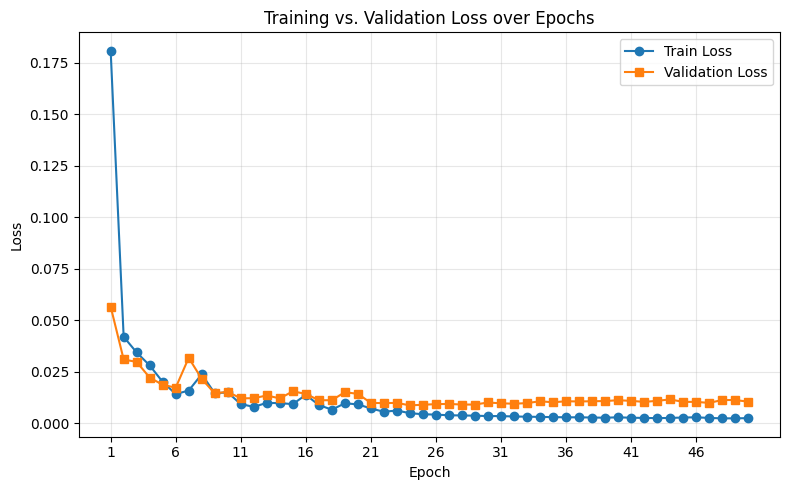
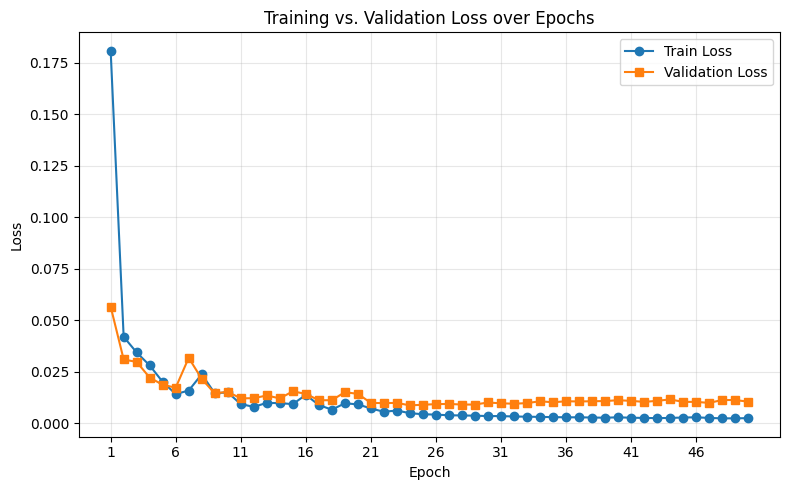

### *BEST Result* <br/>  **Epoch 24: train_loss = 0.0048, val_loss = 0.0086**

In [69]:
# Clear cache
torch.cuda.empty_cache()

In [ ]:
import matplotlib.pyplot as plt

# Replace these lists with your actual loss values in order
train_loss = [
    0.1809, 0.0419, 0.0343, 0.0280, 0.0200, 0.0141, 0.0158, 0.0237, 0.0145, 0.0149,
    0.0092, 0.0079, 0.0098, 0.0097, 0.0092, 0.0137, 0.0088, 0.0065, 0.0096, 0.0091,
    0.0071, 0.0055, 0.0061, 0.0048, 0.0043, 0.0041, 0.0038, 0.0037, 0.0036, 0.0034,
    0.0034, 0.0032, 0.0031, 0.0030, 0.0029, 0.0028, 0.0028, 0.0027, 0.0026, 0.0028,
    0.0026, 0.0025, 0.0024, 0.0025, 0.0027, 0.0028, 0.0025, 0.0023, 0.0023, 0.0024
]

val_loss = [
    0.0566, 0.0309, 0.0297, 0.0221, 0.0186, 0.0172, 0.0317, 0.0215, 0.0144, 0.0152,
    0.0120, 0.0121, 0.0134, 0.0120, 0.0154, 0.0142, 0.0111, 0.0111, 0.0150, 0.0142,
    0.0098, 0.0097, 0.0098, 0.0086, 0.0089, 0.0092, 0.0093, 0.0090, 0.0090, 0.0100,
    0.0096, 0.0094, 0.0097, 0.0106, 0.0101, 0.0106, 0.0105, 0.0106, 0.0107, 0.0111,
    0.0108, 0.0103, 0.0108, 0.0115, 0.0103, 0.0103, 0.0098, 0.0112, 0.0112, 0.0104
]


epochs = list(range(1, len(train_loss) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss,   marker='s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss over Epochs')
plt.xticks(epochs[::5])        # show every 5th epoch on the x-axis
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
def load_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE)
    model.load_state_dict(checkpoint)
    print(f"Checkpoint loaded. Resuming training from epoch {24}")
    
load_checkpoint(model, '/kaggle/working/deeplabv3mobilenet_epoch24.pth')

### Some Predictions

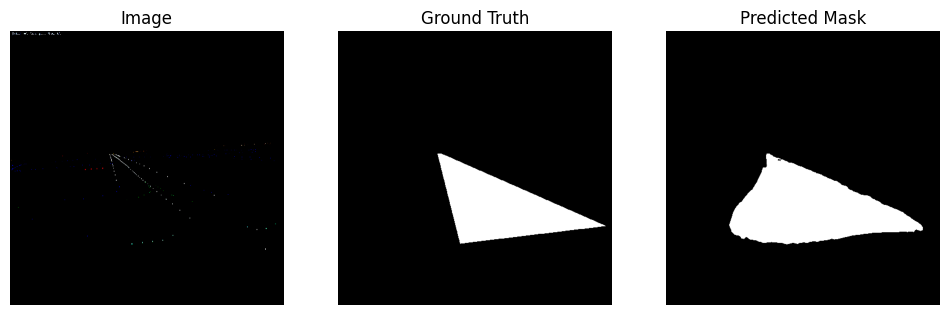

In [23]:
model.eval()
with torch.no_grad():
    imgs, lbls = next(iter(test_loader))
    imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
    preds = model(imgs).cpu()
    preds = torch.sigmoid(preds) > 0.5


img = imgs[3].cpu().permute(1, 2, 0).numpy()
lbl = lbls[3, 0].cpu().numpy()
pred = preds[3, 0].cpu().numpy()

# Visualize 
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(131); plt.imshow(img); plt.title("Image"); plt.axis('off')
plt.subplot(132); plt.imshow(lbl, cmap='gray'); plt.title("Ground Truth"); plt.axis('off')
plt.subplot(133); plt.imshow(pred, cmap='gray'); plt.title("Predicted Mask"); plt.axis('off')
plt.show()


In [24]:
import torch
import time

# 1) Move model to device and set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# 2) Prepare a dummy input (or one real batch) of the right size
#    e.g. batch_size=1, 3×H×W
dummy_input = torch.randn(1, 3, 256, 256, device=device)

# 3) Warm-up (laun-ch a few passes to stabilize the GPU)
with torch.no_grad():
    for _ in range(10):
        _ = model(dummy_input)

# 4) Actual timing with torch.cuda.Event
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

# Number of repeats to average over
n_runs = 100  
times = []

with torch.no_grad():
    for _ in range(n_runs):
        starter.record()           # start timing
        _ = model(dummy_input)     # inference
        ender.record()             # end timing
        # wait for GPU op to finish
        torch.cuda.synchronize()   
        times.append(starter.elapsed_time(ender))  # milliseconds

avg_ms = sum(times) / len(times)
print(f"Avg GPU inference time over {n_runs} runs: {avg_ms:.2f} ms")

# If you want throughput per second:
print(f"≈ {1000/avg_ms:.1f} images/sec")


Avg GPU inference time over 100 runs: 6.58 ms
≈ 152.0 images/sec


---
### **Inference TIME with DeepLabv3+ with Mobilnetv2 encoder = 6.58ms with Validation Loss = 0.0086 in 24 epoches** 
Avg GPU inference time over 100 runs: **6.58 ms**
≈ *152.0 images/sec*

---

## DeepLabV3+ with a lightweight ResNet18 encoder

In [60]:
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None,
)

model = model.to(config.DEVICE)

In [21]:
sum(p.numel() for p in model.parameters())

12329297

In [26]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

criterion = nn.BCEWithLogitsLoss()  # loss function that combines a sigmoid activation and the binary cross-entropy (BCE) loss in a single function best for binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-3)
ACCUMULATION_STEPS = 4

def train_epoch(loader):
    model.train()
    running_loss = 0
    optimizer.zero_grad()

    loop = tqdm(enumerate(loader), total=len(loader), desc=f"Train Epoch {epoch}")
    for step, (imgs, lbls) in loop:
        imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
        preds = model(imgs)
        loss = criterion(preds, lbls) / ACCUMULATION_STEPS  # scale loss

        loss.backward()
        running_loss += loss.item() * ACCUMULATION_STEPS  # un‐scale for logging

        # gradient step once every ACCUMULATION_STEPS
        if (step + 1) % ACCUMULATION_STEPS == 0 or (step + 1) == len(loader):
            optimizer.step()
            optimizer.zero_grad()

        loop.set_postfix({
            "batch_loss": f"{running_loss / (step + 1):.4f}"
        })

    avg_loss = running_loss / len(loader)
    return avg_loss



def eval_epoch(loader, epoch):
    model.eval()
    running_loss = 0.0

    loop = tqdm(enumerate(loader), total=len(loader), desc=f"Eval  Epoch {epoch}", colour="green")
    with torch.no_grad():
        for step, (imgs, lbls) in loop:
            imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
            preds = model(imgs)
            loss = criterion(preds, lbls)

            running_loss += loss.item()
            loop.set_postfix({
                "batch_loss": f"{running_loss / (step + 1):.4f}"
            })

    avg_loss = running_loss / len(loader)
    return avg_loss

In [ ]:
EPOCHS = 50

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(train_loader)
    val_loss = eval_epoch(test_loader, epoch)
    print(f"Epoch {epoch}/{EPOCHS} — train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")

    # Save model
    torch.save(model.state_dict(), f"deeplab_v3_resnet18{epoch}.pth")


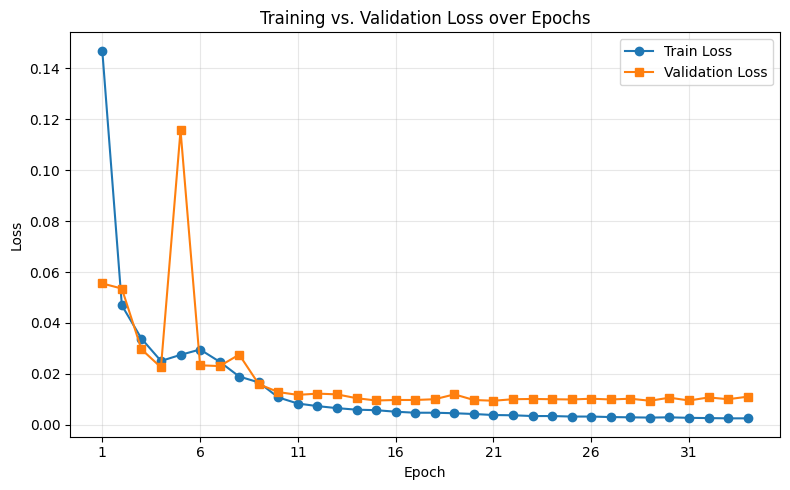
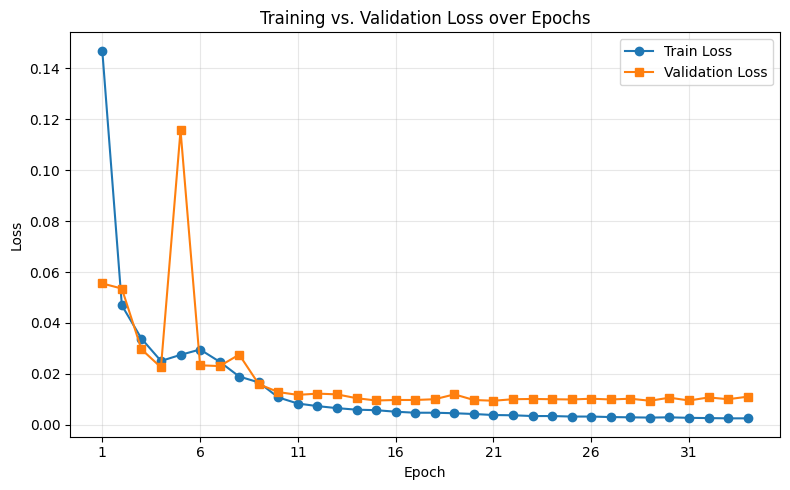

### *BEST Result* <br/>  **Epoch 21: train_loss = 0.0039, val_loss = 0.0095**

In [ ]:
# Clear cache
torch.cuda.empty_cache()

In [ ]:
import matplotlib.pyplot as plt

train_loss = [
    0.1468, 0.0469, 0.0339, 0.0251, 0.0275, 0.0296, 0.0248, 0.0190, 0.0167, 0.0108,
    0.0084, 0.0074, 0.0066, 0.0060, 0.0058, 0.0052, 0.0048, 0.0048, 0.0046, 0.0043,
    0.0039, 0.0038, 0.0035, 0.0035, 0.0033, 0.0033, 0.0031, 0.0030, 0.0029, 0.0030,
    0.0028, 0.0027, 0.0026, 0.0026
]

val_loss = [
    0.0555, 0.0535, 0.0297, 0.0226, 0.1156, 0.0234, 0.0231, 0.0276, 0.0160, 0.0129,
    0.0118, 0.0123, 0.0120, 0.0105, 0.0096, 0.0098, 0.0098, 0.0101, 0.0120, 0.0098,
    0.0095, 0.0101, 0.0102, 0.0101, 0.0100, 0.0103, 0.0100, 0.0103, 0.0095, 0.0107,
    0.0096, 0.0108, 0.0101, 0.0111
]


epochs = list(range(1, len(train_loss) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss,   marker='s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss over Epochs')
plt.xticks(epochs[::5])        # show every 5th epoch on the x-axis
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
Train Epoch 1: 100%|██████████| 175/175 [01:30<00:00,  1.94it/s, batch_loss=0.1468]
Eval  Epoch 1: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s, batch_loss=0.0555]
Epoch 1/50 — train_loss: 0.1468, val_loss: 0.0555

Train Epoch 2: 100%|██████████| 175/175 [01:26<00:00,  2.01it/s, batch_loss=0.0469]
Eval  Epoch 2: 100%|██████████| 75/75 [00:34<00:00,  2.21it/s, batch_loss=0.0535]
Epoch 2/50 — train_loss: 0.0469, val_loss: 0.0535

Train Epoch 3: 100%|██████████| 175/175 [01:27<00:00,  2.00it/s, batch_loss=0.0339]
Eval  Epoch 3: 100%|██████████| 75/75 [00:34<00:00,  2.19it/s, batch_loss=0.0297]
Epoch 3/50 — train_loss: 0.0339, val_loss: 0.0297

Train Epoch 4: 100%|██████████| 175/175 [01:29<00:00,  1.95it/s, batch_loss=0.0251]
Eval  Epoch 4: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s, batch_loss=0.0226]
Epoch 4/50 — train_loss: 0.0251, val_loss: 0.0226

Train Epoch 5: 100%|██████████| 175/175 [01:28<00:00,  1.97it/s, batch_loss=0.0275]
Eval  Epoch 5: 100%|██████████| 75/75 [00:34<00:00,  2.16it/s, batch_loss=0.1156]
Epoch 5/50 — train_loss: 0.0275, val_loss: 0.1156

Train Epoch 6: 100%|██████████| 175/175 [01:28<00:00,  1.97it/s, batch_loss=0.0296]
Eval  Epoch 6: 100%|██████████| 75/75 [00:34<00:00,  2.18it/s, batch_loss=0.0234]
Epoch 6/50 — train_loss: 0.0296, val_loss: 0.0234
Train Epoch 7: 100%|██████████| 175/175 [01:29<00:00,  1.96it/s, batch_loss=0.0248]
Eval  Epoch 7: 100%|██████████| 75/75 [00:34<00:00,  2.18it/s, batch_loss=0.0231]
Epoch 7/50 — train_loss: 0.0248, val_loss: 0.0231

Train Epoch 8: 100%|██████████| 175/175 [01:27<00:00,  1.99it/s, batch_loss=0.0190]
Eval  Epoch 8: 100%|██████████| 75/75 [00:34<00:00,  2.15it/s, batch_loss=0.0276]
Epoch 8/50 — train_loss: 0.0190, val_loss: 0.0276

Train Epoch 9: 100%|██████████| 175/175 [01:28<00:00,  1.98it/s, batch_loss=0.0167]
Eval  Epoch 9: 100%|██████████| 75/75 [00:34<00:00,  2.14it/s, batch_loss=0.0160]
Epoch 9/50 — train_loss: 0.0167, val_loss: 0.0160

Train Epoch 10: 100%|██████████| 175/175 [01:28<00:00,  1.98it/s, batch_loss=0.0108]
Eval  Epoch 10: 100%|██████████| 75/75 [00:34<00:00,  2.16it/s, batch_loss=0.0129]
Epoch 10/50 — train_loss: 0.0108, val_loss: 0.0129

Train Epoch 11: 100%|██████████| 175/175 [01:27<00:00,  1.99it/s, batch_loss=0.0084]
Eval  Epoch 11: 100%|██████████| 75/75 [00:34<00:00,  2.20it/s, batch_loss=0.0118]
Epoch 11/50 — train_loss: 0.0084, val_loss: 0.0118

Train Epoch 12: 100%|██████████| 175/175 [01:28<00:00,  1.98it/s, batch_loss=0.0074]
Eval  Epoch 12: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s, batch_loss=0.0123]
Epoch 12/50 — train_loss: 0.0074, val_loss: 0.0123

Train Epoch 13: 100%|██████████| 175/175 [01:28<00:00,  1.98it/s, batch_loss=0.0066]
Eval  Epoch 13: 100%|██████████| 75/75 [00:34<00:00,  2.16it/s, batch_loss=0.0120]
Epoch 13/50 — train_loss: 0.0066, val_loss: 0.0120

Train Epoch 14: 100%|██████████| 175/175 [01:28<00:00,  1.98it/s, batch_loss=0.0060]
Eval  Epoch 14: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s, batch_loss=0.0105]
Epoch 14/50 — train_loss: 0.0060, val_loss: 0.0105

Train Epoch 15: 100%|██████████| 175/175 [01:28<00:00,  1.98it/s, batch_loss=0.0058]
Eval  Epoch 15: 100%|██████████| 75/75 [00:34<00:00,  2.18it/s, batch_loss=0.0096]
Epoch 15/50 — train_loss: 0.0058, val_loss: 0.0096

Train Epoch 16: 100%|██████████| 175/175 [01:27<00:00,  2.00it/s, batch_loss=0.0052]
Eval  Epoch 16: 100%|██████████| 75/75 [00:34<00:00,  2.18it/s, batch_loss=0.0098]
Epoch 16/50 — train_loss: 0.0052, val_loss: 0.0098

Train Epoch 17: 100%|██████████| 175/175 [01:28<00:00,  1.98it/s, batch_loss=0.0048]
Eval  Epoch 17: 100%|██████████| 75/75 [00:34<00:00,  2.16it/s, batch_loss=0.0098]
Epoch 17/50 — train_loss: 0.0048, val_loss: 0.0098

Train Epoch 18: 100%|██████████| 175/175 [01:28<00:00,  1.98it/s, batch_loss=0.0048]
Eval  Epoch 18: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s, batch_loss=0.0101]
Epoch 18/50 — train_loss: 0.0048, val_loss: 0.0101

Train Epoch 19: 100%|██████████| 175/175 [01:28<00:00,  1.97it/s, batch_loss=0.0046]
Eval  Epoch 19: 100%|██████████| 75/75 [00:34<00:00,  2.19it/s, batch_loss=0.0120]
Epoch 19/50 — train_loss: 0.0046, val_loss: 0.0120

Train Epoch 20: 100%|██████████| 175/175 [01:26<00:00,  2.01it/s, batch_loss=0.0043]
Eval  Epoch 20: 100%|██████████| 75/75 [00:34<00:00,  2.19it/s, batch_loss=0.0098]
Epoch 20/50 — train_loss: 0.0043, val_loss: 0.0098

Train Epoch 21: 100%|██████████| 175/175 [01:27<00:00,  2.00it/s, batch_loss=0.0039]
Eval  Epoch 21: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s, batch_loss=0.0095]
Epoch 21/50 — train_loss: 0.0039, val_loss: 0.0095

Train Epoch 22: 100%|██████████| 175/175 [01:29<00:00,  1.96it/s, batch_loss=0.0038]
Eval  Epoch 22: 100%|██████████| 75/75 [00:34<00:00,  2.16it/s, batch_loss=0.0101]
Epoch 22/50 — train_loss: 0.0038, val_loss: 0.0101

Train Epoch 23: 100%|██████████| 175/175 [01:27<00:00,  1.99it/s, batch_loss=0.0035]
Eval  Epoch 23: 100%|██████████| 75/75 [00:34<00:00,  2.15it/s, batch_loss=0.0102]
Epoch 23/50 — train_loss: 0.0035, val_loss: 0.0102

Train Epoch 24: 100%|██████████| 175/175 [01:28<00:00,  1.97it/s, batch_loss=0.0035]
Eval  Epoch 24: 100%|██████████| 75/75 [00:34<00:00,  2.16it/s, batch_loss=0.0101]
Epoch 24/50 — train_loss: 0.0035, val_loss: 0.0101

Train Epoch 25: 100%|██████████| 175/175 [01:27<00:00,  2.00it/s, batch_loss=0.0033]
Eval  Epoch 25: 100%|██████████| 75/75 [00:34<00:00,  2.15it/s, batch_loss=0.0100]
Epoch 25/50 — train_loss: 0.0033, val_loss: 0.0100

Train Epoch 26: 100%|██████████| 175/175 [01:26<00:00,  2.02it/s, batch_loss=0.0033]
Eval  Epoch 26: 100%|██████████| 75/75 [00:34<00:00,  2.18it/s, batch_loss=0.0103]
Epoch 26/50 — train_loss: 0.0033, val_loss: 0.0103

Train Epoch 27: 100%|██████████| 175/175 [01:27<00:00,  2.01it/s, batch_loss=0.0031]
Eval  Epoch 27: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s, batch_loss=0.0100]
Epoch 27/50 — train_loss: 0.0031, val_loss: 0.0100

Train Epoch 28: 100%|██████████| 175/175 [01:28<00:00,  1.99it/s, batch_loss=0.0030]
Eval  Epoch 28: 100%|██████████| 75/75 [00:34<00:00,  2.16it/s, batch_loss=0.0103]
Epoch 28/50 — train_loss: 0.0030, val_loss: 0.0103

Train Epoch 29: 100%|██████████| 175/175 [01:27<00:00,  2.00it/s, batch_loss=0.0029]
Eval  Epoch 29: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s, batch_loss=0.0095]
Epoch 29/50 — train_loss: 0.0029, val_loss: 0.0095

Train Epoch 30: 100%|██████████| 175/175 [01:26<00:00,  2.02it/s, batch_loss=0.0030]
Eval  Epoch 30: 100%|██████████| 75/75 [00:34<00:00,  2.19it/s, batch_loss=0.0107]
Epoch 30/50 — train_loss: 0.0030, val_loss: 0.0107
Train Epoch 31: 100%|██████████| 175/175 [01:27<00:00,  1.99it/s, batch_loss=0.0028]
Eval  Epoch 31: 100%|██████████| 75/75 [00:35<00:00,  2.14it/s, batch_loss=0.0096]
Epoch 31/50 — train_loss: 0.0028, val_loss: 0.0096

Train Epoch 32: 100%|██████████| 175/175 [01:28<00:00,  1.97it/s, batch_loss=0.0027]
Eval  Epoch 32: 100%|██████████| 75/75 [00:34<00:00,  2.19it/s, batch_loss=0.0108]
Epoch 32/50 — train_loss: 0.0027, val_loss: 0.0108

Train Epoch 33: 100%|██████████| 175/175 [01:29<00:00,  1.96it/s, batch_loss=0.0026]
Eval  Epoch 33: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s, batch_loss=0.0101]
Epoch 33/50 — train_loss: 0.0026, val_loss: 0.0101

Train Epoch 34: 100%|██████████| 175/175 [01:28<00:00,  1.98it/s, batch_loss=0.0026]
Eval  Epoch 34: 100%|██████████| 75/75 [00:34<00:00,  2.19it/s, batch_loss=0.0111]
Epoch 34/50 — train_loss: 0.0026, val_loss: 0.0111

Train Epoch 35: 100%|██████████| 175/175 [01:28<00:00,  1.98it/s, batch_loss=0.0251]
Eval  Epoch 35: 100%|██████████| 75/75 [00:35<00:00,  2.12it/s, batch_loss=0.0613]
Epoch 35/50 — train_loss: 0.0251, val_loss: 0.0613

In [61]:
def load_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE)
    model.load_state_dict(checkpoint)
    print(f"Checkpoint loaded. Resuming training from epoch {21}")
    
load_checkpoint(model, '/kaggle/working/deeplab_v3_resnet1821.pth')

Checkpoint loaded. Resuming training from epoch 21


### Some Predictions

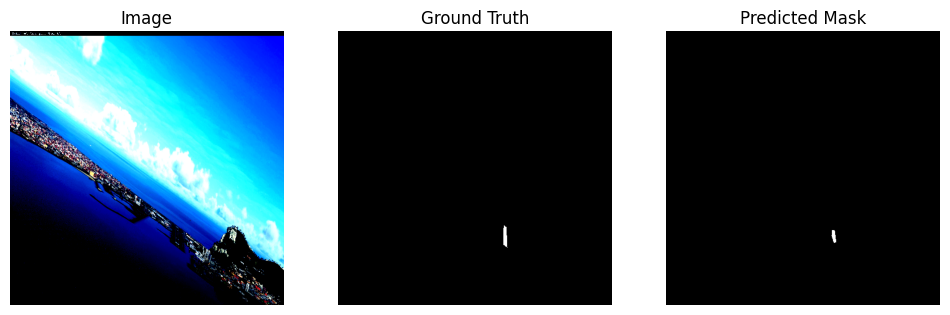

In [62]:
model.eval()
with torch.no_grad():
    imgs, lbls = next(iter(test_loader))
    imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
    preds = model(imgs).cpu()
    preds = torch.sigmoid(preds) > 0.5


img = imgs[1].cpu().permute(1, 2, 0).numpy()
lbl = lbls[1, 0].cpu().numpy()
pred = preds[1, 0].cpu().numpy()

# Visualize 
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(131); plt.imshow(img); plt.title("Image"); plt.axis('off')
plt.subplot(132); plt.imshow(lbl, cmap='gray'); plt.title("Ground Truth"); plt.axis('off')
plt.subplot(133); plt.imshow(pred, cmap='gray'); plt.title("Predicted Mask"); plt.axis('off')
plt.show()


In [34]:
import torch
import time

# 1) Move model to device and set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# 2) Prepare a dummy input (or one real batch) of the right size
#    e.g. batch_size=1, 3×H×W
dummy_input = torch.randn(1, 3, 256, 256, device=device)

# 3) Warm-up (laun-ch a few passes to stabilize the GPU)
with torch.no_grad():
    for _ in range(10):
        _ = model(dummy_input)

# 4) Actual timing with torch.cuda.Event
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

# Number of repeats to average over
n_runs = 100  
times = []

with torch.no_grad():
    for _ in range(n_runs):
        starter.record()           # start timing
        _ = model(dummy_input)     # inference
        ender.record()             # end timing
        # wait for GPU op to finish
        torch.cuda.synchronize()   
        times.append(starter.elapsed_time(ender))  # milliseconds

avg_ms = sum(times) / len(times)
print(f"Avg GPU inference time over {n_runs} runs: {avg_ms:.2f} ms")

# If you want throughput per second:
print(f"≈ {1000/avg_ms:.1f} images/sec")


Avg GPU inference time over 100 runs: 4.94 ms
≈ 202.5 images/sec


---
### **Inference TIME of DeepLabv3+ Resnet18 encoder - 4.94ms with Validation Loss = 0.0095 in epoch 21** 
Avg GPU inference time over 100 runs: **4.94 ms**
≈ *202.5 images/sec*

---

## Unet and efficientnet-b0 

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None,               # raw logits → use BCEWithLogitsLoss
    decoder_attention_type="scse", # adds lightweight attention
)
model = model.to(config.DEVICE)

In [23]:
sum(p.numel() for p in model.parameters())

6303492

In [17]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

criterion = nn.BCEWithLogitsLoss()  # loss function that combines a sigmoid activation and the binary cross-entropy (BCE) loss in a single function best for binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-3)
ACCUMULATION_STEPS = 4

def train_epoch(loader):
    model.train()
    running_loss = 0
    optimizer.zero_grad()

    loop = tqdm(enumerate(loader), total=len(loader), desc=f"Train Epoch {epoch}")
    for step, (imgs, lbls) in loop:
        imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
        preds = model(imgs)
        loss = criterion(preds, lbls) / ACCUMULATION_STEPS  # scale loss

        loss.backward()
        running_loss += loss.item() * ACCUMULATION_STEPS  # un‐scale for logging

        # gradient step once every ACCUMULATION_STEPS
        if (step + 1) % ACCUMULATION_STEPS == 0 or (step + 1) == len(loader):
            optimizer.step()
            optimizer.zero_grad()

        loop.set_postfix({
            "batch_loss": f"{running_loss / (step + 1):.4f}"
        })

    avg_loss = running_loss / len(loader)
    return avg_loss



def eval_epoch(loader, epoch):
    model.eval()
    running_loss = 0.0

    loop = tqdm(enumerate(loader), total=len(loader), desc=f"Eval  Epoch {epoch}", colour="green")
    with torch.no_grad():
        for step, (imgs, lbls) in loop:
            imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
            preds = model(imgs)
            loss = criterion(preds, lbls)

            running_loss += loss.item()
            loop.set_postfix({
                "batch_loss": f"{running_loss / (step + 1):.4f}"
            })

    avg_loss = running_loss / len(loader)
    return avg_loss

In [ ]:
EPOCHS = 50

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(train_loader)
    val_loss = eval_epoch(test_loader, epoch)
    print(f"Epoch {epoch}/{EPOCHS} — train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")

    # Save model
    torch.save(model.state_dict(), f"deeplabv3mobilenet_epoch{epoch}.pth")


In [ ]:
Train Epoch 2: 100%|██████████| 175/175 [01:40<00:00,  1.75it/s, batch_loss=0.0774]
Eval  Epoch 2: 100%|██████████| 75/75 [00:35<00:00,  2.10it/s, batch_loss=0.0499]
Epoch 2/50 — train_loss: 0.0774, val_loss: 0.0499

Train Epoch 3: 100%|██████████| 175/175 [01:40<00:00,  1.75it/s, batch_loss=0.0382]
Eval  Epoch 3: 100%|██████████| 75/75 [00:36<00:00,  2.07it/s, batch_loss=0.0274]
Epoch 3/50 — train_loss: 0.0382, val_loss: 0.0274

Train Epoch 4: 100%|██████████| 175/175 [01:40<00:00,  1.75it/s, batch_loss=0.0260]
Eval  Epoch 4: 100%|██████████| 75/75 [00:35<00:00,  2.08it/s, batch_loss=0.0211]
Epoch 4/50 — train_loss: 0.0260, val_loss: 0.0211

Train Epoch 5: 100%|██████████| 175/175 [01:39<00:00,  1.75it/s, batch_loss=0.0191]
Eval  Epoch 5: 100%|██████████| 75/75 [00:35<00:00,  2.10it/s, batch_loss=0.0191]
Epoch 5/50 — train_loss: 0.0191, val_loss: 0.0191

Train Epoch 6: 100%|██████████| 175/175 [01:40<00:00,  1.75it/s, batch_loss=0.0126]
Eval  Epoch 6: 100%|██████████| 75/75 [00:35<00:00,  2.09it/s, batch_loss=0.0144]
Epoch 6/50 — train_loss: 0.0126, val_loss: 0.0144

Train Epoch 7: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0101]
Eval  Epoch 7: 100%|██████████| 75/75 [00:36<00:00,  2.03it/s, batch_loss=0.0129]
Epoch 7/50 — train_loss: 0.0101, val_loss: 0.0129

Train Epoch 8: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0187]
Eval  Epoch 8: 100%|██████████| 75/75 [00:36<00:00,  2.08it/s, batch_loss=0.0478]
Epoch 8/50 — train_loss: 0.0187, val_loss: 0.0478

Train Epoch 9: 100%|██████████| 175/175 [01:39<00:00,  1.75it/s, batch_loss=0.0144]
Eval  Epoch 9: 100%|██████████| 75/75 [00:36<00:00,  2.05it/s, batch_loss=0.0180]
Epoch 9/50 — train_loss: 0.0144, val_loss: 0.0180

Train Epoch 10: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0120]
Eval  Epoch 10: 100%|██████████| 75/75 [00:36<00:00,  2.04it/s, batch_loss=0.0180]
Epoch 10/50 — train_loss: 0.0120, val_loss: 0.0180

Train Epoch 11: 100%|██████████| 175/175 [01:40<00:00,  1.75it/s, batch_loss=0.0085]
Eval  Epoch 11: 100%|██████████| 75/75 [00:36<00:00,  2.06it/s, batch_loss=0.0116]
Epoch 11/50 — train_loss: 0.0085, val_loss: 0.0116

Train Epoch 12: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0066]
Eval  Epoch 12: 100%|██████████| 75/75 [00:35<00:00,  2.09it/s, batch_loss=0.0133]
Epoch 12/50 — train_loss: 0.0066, val_loss: 0.0133

Train Epoch 13: 100%|██████████| 175/175 [01:40<00:00,  1.75it/s, batch_loss=0.0057]
Eval  Epoch 13: 100%|██████████| 75/75 [00:36<00:00,  2.04it/s, batch_loss=0.0112]
Epoch 13/50 — train_loss: 0.0057, val_loss: 0.0112

Train Epoch 14: 100%|██████████| 175/175 [01:43<00:00,  1.69it/s, batch_loss=0.0050]
Eval  Epoch 14: 100%|██████████| 75/75 [00:36<00:00,  2.05it/s, batch_loss=0.0114]
Epoch 14/50 — train_loss: 0.0050, val_loss: 0.0114

Train Epoch 15: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0051]
Eval  Epoch 15: 100%|██████████| 75/75 [00:36<00:00,  2.05it/s, batch_loss=0.0127]
Epoch 15/50 — train_loss: 0.0051, val_loss: 0.0127

Train Epoch 16: 100%|██████████| 175/175 [01:40<00:00,  1.75it/s, batch_loss=0.0062]
Eval  Epoch 16: 100%|██████████| 75/75 [00:35<00:00,  2.08it/s, batch_loss=0.0108]
Epoch 16/50 — train_loss: 0.0062, val_loss: 0.0108

Train Epoch 17: 100%|██████████| 175/175 [01:40<00:00,  1.75it/s, batch_loss=0.0051]
Eval  Epoch 17: 100%|██████████| 75/75 [00:36<00:00,  2.08it/s, batch_loss=0.0112]
Epoch 17/50 — train_loss: 0.0051, val_loss: 0.0112

Train Epoch 18: 100%|██████████| 175/175 [01:41<00:00,  1.72it/s, batch_loss=0.0076]
Eval  Epoch 18: 100%|██████████| 75/75 [00:36<00:00,  2.04it/s, batch_loss=0.0139]
Epoch 18/50 — train_loss: 0.0076, val_loss: 0.0139

Train Epoch 19: 100%|██████████| 175/175 [01:44<00:00,  1.67it/s, batch_loss=0.0056]
Eval  Epoch 19: 100%|██████████| 75/75 [00:36<00:00,  2.06it/s, batch_loss=0.0119]
Epoch 19/50 — train_loss: 0.0056, val_loss: 0.0119

Train Epoch 20: 100%|██████████| 175/175 [01:40<00:00,  1.75it/s, batch_loss=0.0060]
Eval  Epoch 20: 100%|██████████| 75/75 [00:36<00:00,  2.07it/s, batch_loss=0.0109]
Epoch 20/50 — train_loss: 0.0060, val_loss: 0.0109

Train Epoch 21: 100%|██████████| 175/175 [01:40<00:00,  1.75it/s, batch_loss=0.0210]
Eval  Epoch 21: 100%|██████████| 75/75 [00:36<00:00,  2.06it/s, batch_loss=0.0232]
Epoch 21/50 — train_loss: 0.0210, val_loss: 0.0232

Train Epoch 22: 100%|██████████| 175/175 [01:41<00:00,  1.73it/s, batch_loss=0.0153]
Eval  Epoch 22: 100%|██████████| 75/75 [00:36<00:00,  2.05it/s, batch_loss=0.0169]
Epoch 22/50 — train_loss: 0.0153, val_loss: 0.0169

Train Epoch 23: 100%|██████████| 175/175 [01:40<00:00,  1.75it/s, batch_loss=0.0077]
Eval  Epoch 23: 100%|██████████| 75/75 [00:36<00:00,  2.07it/s, batch_loss=0.0135]
Epoch 23/50 — train_loss: 0.0077, val_loss: 0.0135

Train Epoch 24: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0061]
Eval  Epoch 24: 100%|██████████| 75/75 [00:36<00:00,  2.05it/s, batch_loss=0.0100]
Epoch 24/50 — train_loss: 0.0061, val_loss: 0.0100

Train Epoch 25: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0071]
Eval  Epoch 25: 100%|██████████| 75/75 [00:37<00:00,  2.01it/s, batch_loss=0.0100]
Epoch 25/50 — train_loss: 0.0071, val_loss: 0.0100

Train Epoch 26: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0089]
Eval  Epoch 26: 100%|██████████| 75/75 [00:35<00:00,  2.09it/s, batch_loss=0.0175]
Epoch 26/50 — train_loss: 0.0089, val_loss: 0.0175

Train Epoch 27: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0107]
Eval  Epoch 27: 100%|██████████| 75/75 [00:35<00:00,  2.08it/s, batch_loss=0.0112]
Epoch 27/50 — train_loss: 0.0107, val_loss: 0.0112

Train Epoch 28: 100%|██████████| 175/175 [01:43<00:00,  1.69it/s, batch_loss=0.0053]
Eval  Epoch 28: 100%|██████████| 75/75 [00:36<00:00,  2.06it/s, batch_loss=0.0104]
Epoch 28/50 — train_loss: 0.0053, val_loss: 0.0104

Train Epoch 29: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0041]
Eval  Epoch 29: 100%|██████████| 75/75 [00:36<00:00,  2.06it/s, batch_loss=0.0094]
Epoch 29/50 — train_loss: 0.0041, val_loss: 0.0094

Train Epoch 30: 100%|██████████| 175/175 [01:47<00:00,  1.63it/s, batch_loss=0.0040]
Eval  Epoch 30: 100%|██████████| 75/75 [00:36<00:00,  2.08it/s, batch_loss=0.0094]
Epoch 30/50 — train_loss: 0.0040, val_loss: 0.0094

Train Epoch 31: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0038]
Eval  Epoch 31: 100%|██████████| 75/75 [00:35<00:00,  2.09it/s, batch_loss=0.0099]
Epoch 31/50 — train_loss: 0.0038, val_loss: 0.0099

Train Epoch 32: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0039]
Eval  Epoch 32: 100%|██████████| 75/75 [00:36<00:00,  2.06it/s, batch_loss=0.0100]
Epoch 32/50 — train_loss: 0.0039, val_loss: 0.0100

Train Epoch 33: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0040]
Eval  Epoch 33: 100%|██████████| 75/75 [00:36<00:00,  2.03it/s, batch_loss=0.0092]
Epoch 33/50 — train_loss: 0.0040, val_loss: 0.0092

Train Epoch 34: 100%|██████████| 175/175 [01:40<00:00,  1.75it/s, batch_loss=0.0035]
Eval  Epoch 34: 100%|██████████| 75/75 [00:36<00:00,  2.06it/s, batch_loss=0.0089]
Epoch 34/50 — train_loss: 0.0035, val_loss: 0.0089

Train Epoch 35: 100%|██████████| 175/175 [01:40<00:00,  1.75it/s, batch_loss=0.0035]
Eval  Epoch 35: 100%|██████████| 75/75 [00:36<00:00,  2.06it/s, batch_loss=0.0098]
Epoch 35/50 — train_loss: 0.0035, val_loss: 0.0098

Train Epoch 36: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0033]
Eval  Epoch 36: 100%|██████████| 75/75 [00:36<00:00,  2.07it/s, batch_loss=0.0100]
Epoch 36/50 — train_loss: 0.0033, val_loss: 0.0100

Train Epoch 37: 100%|██████████| 175/175 [01:41<00:00,  1.73it/s, batch_loss=0.0036]
Eval  Epoch 37: 100%|██████████| 75/75 [00:36<00:00,  2.04it/s, batch_loss=0.0102]
Epoch 37/50 — train_loss: 0.0036, val_loss: 0.0102

Train Epoch 38: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0036]
Eval  Epoch 38: 100%|██████████| 75/75 [00:37<00:00,  2.02it/s, batch_loss=0.0112]
Epoch 38/50 — train_loss: 0.0036, val_loss: 0.0112

Train Epoch 39: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0034]
Eval  Epoch 39: 100%|██████████| 75/75 [00:36<00:00,  2.07it/s, batch_loss=0.0091]
Epoch 39/50 — train_loss: 0.0034, val_loss: 0.0091

Train Epoch 40: 100%|██████████| 175/175 [01:40<00:00,  1.75it/s, batch_loss=0.0033]
Eval  Epoch 40: 100%|██████████| 75/75 [00:36<00:00,  2.08it/s, batch_loss=0.0094]
Epoch 40/50 — train_loss: 0.0033, val_loss: 0.0094

Train Epoch 41: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0034]
Eval  Epoch 41: 100%|██████████| 75/75 [00:35<00:00,  2.10it/s, batch_loss=0.0100]
Epoch 41/50 — train_loss: 0.0034, val_loss: 0.0100

Train Epoch 42: 100%|██████████| 175/175 [01:40<00:00,  1.75it/s, batch_loss=0.0034]
Eval  Epoch 42: 100%|██████████| 75/75 [00:36<00:00,  2.07it/s, batch_loss=0.0096]
Epoch 42/50 — train_loss: 0.0034, val_loss: 0.0096

Train Epoch 43: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0029]
Eval  Epoch 43: 100%|██████████| 75/75 [00:36<00:00,  2.07it/s, batch_loss=0.0102]
Epoch 43/50 — train_loss: 0.0029, val_loss: 0.0102

Train Epoch 44: 100%|██████████| 175/175 [01:40<00:00,  1.75it/s, batch_loss=0.0028]
Eval  Epoch 44: 100%|██████████| 75/75 [00:36<00:00,  2.07it/s, batch_loss=0.0108]
Epoch 44/50 — train_loss: 0.0028, val_loss: 0.0108

Train Epoch 45: 100%|██████████| 175/175 [01:40<00:00,  1.75it/s, batch_loss=0.0027]
Eval  Epoch 45: 100%|██████████| 75/75 [00:36<00:00,  2.04it/s, batch_loss=0.0089]
Epoch 45/50 — train_loss: 0.0027, val_loss: 0.0089

Train Epoch 46: 100%|██████████| 175/175 [01:39<00:00,  1.75it/s, batch_loss=0.0026]
Eval  Epoch 46: 100%|██████████| 75/75 [00:36<00:00,  2.06it/s, batch_loss=0.0092]
Epoch 46/50 — train_loss: 0.0026, val_loss: 0.0092

Train Epoch 47: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0025]
Eval  Epoch 47: 100%|██████████| 75/75 [00:36<00:00,  2.03it/s, batch_loss=0.0108]
Epoch 47/50 — train_loss: 0.0025, val_loss: 0.0108

Train Epoch 48: 100%|██████████| 175/175 [01:41<00:00,  1.73it/s, batch_loss=0.0025]
Eval  Epoch 48: 100%|██████████| 75/75 [00:36<00:00,  2.07it/s, batch_loss=0.0092]
Epoch 48/50 — train_loss: 0.0025, val_loss: 0.0092

Train Epoch 49: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, batch_loss=0.0024]
Eval  Epoch 49: 100%|██████████| 75/75 [00:36<00:00,  2.06it/s, batch_loss=0.0096]
Epoch 49/50 — train_loss: 0.0024, val_loss: 0.0096

Train Epoch 50: 100%|██████████| 175/175 [01:41<00:00,  1.73it/s, batch_loss=0.0023]
Eval  Epoch 50: 100%|██████████| 75/75 [00:35<00:00,  2.10it/s, batch_loss=0.0095]
Epoch 50/50 — train_loss: 0.0023, val_loss: 0.0095

In [50]:
torch.cuda.empty_cache()

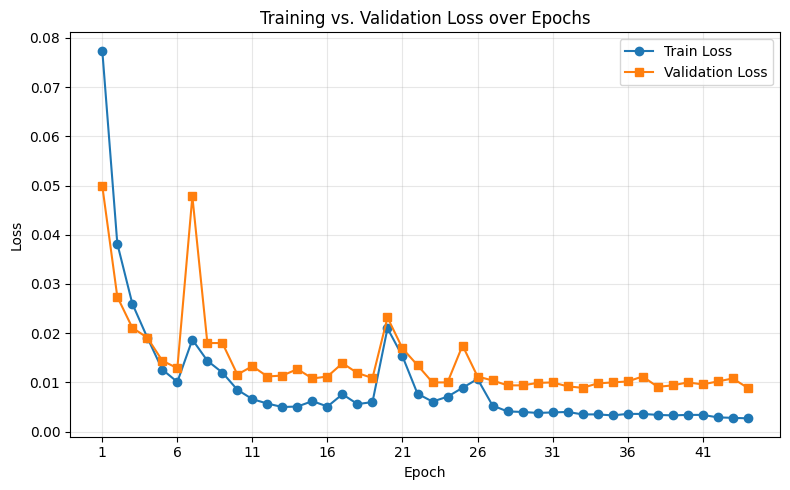
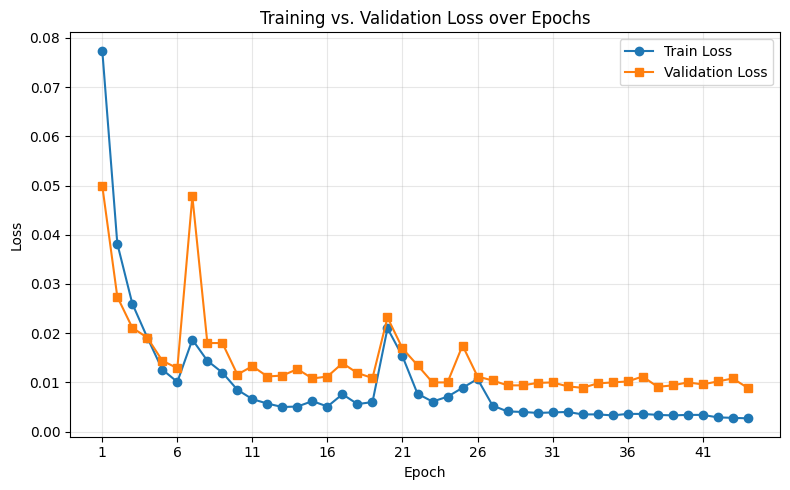

### *BEST Result* <br/>  **Epoch 34: train_loss = 0.0035, val_loss = 0.0089**

In [ ]:
import matplotlib.pyplot as plt

train_loss = [
    0.0774, 0.0382, 0.0260, 0.0191, 0.0126, 0.0101, 0.0187, 0.0144, 0.0120, 0.0085,
    0.0066, 0.0057, 0.0050, 0.0051, 0.0062, 0.0051, 0.0076, 0.0056, 0.0060, 0.0210,
    0.0153, 0.0077, 0.0061, 0.0071, 0.0089, 0.0107, 0.0053, 0.0041, 0.0040, 0.0038,
    0.0039, 0.0040, 0.0035, 0.0035, 0.0033, 0.0036, 0.0036, 0.0034, 0.0033, 0.0034,
    0.0034, 0.0029, 0.0028, 0.0027
]

val_loss = [
    0.0499, 0.0274, 0.0211, 0.0191, 0.0144, 0.0129, 0.0478, 0.0180, 0.0180, 0.0116,
    0.0133, 0.0112, 0.0114, 0.0127, 0.0108, 0.0112, 0.0139, 0.0119, 0.0109, 0.0232,
    0.0169, 0.0135, 0.0100, 0.0100, 0.0175, 0.0112, 0.0104, 0.0094, 0.0094, 0.0099,
    0.0100, 0.0092, 0.0089, 0.0098, 0.0100, 0.0102, 0.0112, 0.0091, 0.0094, 0.0100,
    0.0096, 0.0102, 0.0108, 0.0089
]


epochs = list(range(1, len(train_loss) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss,   marker='s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss over Epochs')
plt.xticks(epochs[::5])        # show every 5th epoch on the x-axis
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Some Predicctions

In [53]:
def load_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE)
    model.load_state_dict(checkpoint)
    print(f"Checkpoint loaded. Resuming training from epoch {34}")
    
load_checkpoint(model, '/kaggle/working/deeplabv3mobilenet_epoch34.pth')

Checkpoint loaded. Resuming training from epoch 34


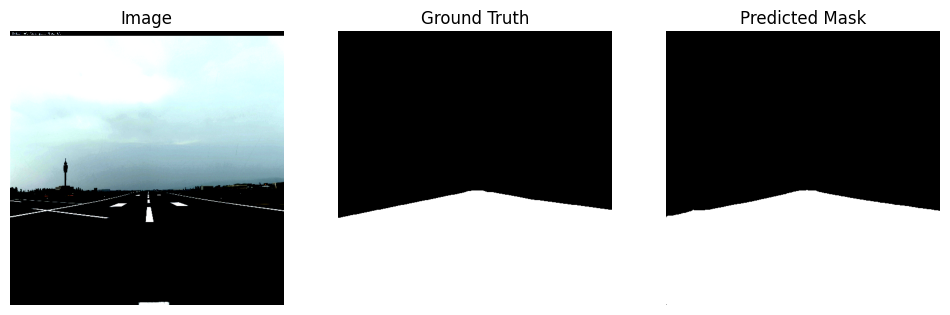

In [59]:
model.eval()
with torch.no_grad():
    imgs, lbls = next(iter(test_loader))
    imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
    preds = model(imgs).cpu()
    preds = torch.sigmoid(preds) > 0.5


img = imgs[0].cpu().permute(1, 2, 0).numpy()
lbl = lbls[0, 0].cpu().numpy()
pred = preds[0|, 0].cpu().numpy()

# Visualize 
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(131); plt.imshow(img); plt.title("Image"); plt.axis('off')
plt.subplot(132); plt.imshow(lbl, cmap='gray'); plt.title("Ground Truth"); plt.axis('off')
plt.subplot(133); plt.imshow(pred, cmap='gray'); plt.title("Predicted Mask"); plt.axis('off')
plt.show()


In [27]:
import torch
import time

# 1) Move model to device and set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# 2) Prepare a dummy input (or one real batch) of the right size
#    e.g. batch_size=1, 3×H×W
dummy_input = torch.randn(1, 3, 256, 256, device=device)

# 3) Warm-up (laun-ch a few passes to stabilize the GPU)
with torch.no_grad():
    for _ in range(10):
        _ = model(dummy_input)

# 4) Actual timing with torch.cuda.Event
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

# Number of repeats to average over
n_runs = 100  
times = []

with torch.no_grad():
    for _ in range(n_runs):
        starter.record()           # start timing
        _ = model(dummy_input)     # inference
        ender.record()             # end timing
        # wait for GPU op to finish
        torch.cuda.synchronize()   
        times.append(starter.elapsed_time(ender))  # milliseconds

avg_ms = sum(times) / len(times)
print(f"Avg GPU inference time over {n_runs} runs: {avg_ms:.2f} ms")

# If you want throughput per second:
print(f"≈ {1000/avg_ms:.1f} images/sec")


Avg GPU inference time over 100 runs: 12.90 ms
≈ 77.5 images/sec


---
### **Inference TIME of Unet with efficientnetb0 encoder - 12.90ms with Validation Loss = 0.0089 with 34 epoches** 
Avg GPU inference time over 100 runs: **12.90 ms**
≈ *77.5 images/sec*

---

## Axial Unet

In [82]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

# Axial Attention block: height then width, with residual FFN
class AxialAttention(nn.Module):
    def __init__(self, dim, num_heads=8, dropout=0.1, ffn_dim=None):
        super().__init__()
        self.height_attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout)
        self.width_attn  = nn.MultiheadAttention(dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        # simple feed-forward network after attention
        ffn_dim = ffn_dim or dim * 2
        self.ffn = nn.Sequential(
            nn.Linear(dim, ffn_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(ffn_dim, dim),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [B, C, H, W]
        B, C, H, W = x.shape
        # Height attention
        x_h = x.permute(0, 3, 2, 1).reshape(B*W, H, C)  # [B*W, H, C]
        x_h = x_h.permute(1, 0, 2)                      # [H, B*W, C]
        attn_h, _ = self.height_attn(x_h, x_h, x_h)
        attn_h = attn_h.permute(1, 0, 2).reshape(B, W, H, C).permute(0,3,2,1)
        x = x + self.dropout(attn_h)
        # FFN
        x_flat = x.permute(0,2,3,1).reshape(-1, C)
        ffn_out = self.ffn(x_flat)
        ffn_out = ffn_out.reshape(B, H, W, C).permute(0,3,1,2)
        x = x + ffn_out
        x = x.permute(0,2,3,1).reshape(-1, C)
        x = self.norm1(x).reshape(B, H, W, C).permute(0,3,1,2)

        # Width attention
        x_w = x.permute(0,2,3,1).reshape(B*H, W, C)     # [B*H, W, C]
        x_w = x_w.permute(1,0,2)                        # [W, B*H, C]
        attn_w, _ = self.width_attn(x_w, x_w, x_w)
        attn_w = attn_w.permute(1,0,2).reshape(B, H, W, C).permute(0,3,1,2)
        x = x + self.dropout(attn_w)
        # FFN
        x_flat = x.permute(0,2,3,1).reshape(-1, C)
        ffn_out = self.ffn(x_flat)
        ffn_out = ffn_out.reshape(B, H, W, C).permute(0,3,1,2)
        x = x + ffn_out
        x = x.permute(0,2,3,1).reshape(-1, C)
        x = self.norm2(x).reshape(B, H, W, C).permute(0,3,1,2)
        return x

# Basic Conv block using GroupNorm
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

# Axial Attention U-Net with 512x512 support
class AxialUNet(nn.Module):
    def __init__(self, num_classes=1, base_channels=64):
        super().__init__()
        # Use pretrained encoder for better convergence
        backbone = resnet18(pretrained=True)
        # Encoder layers
        self.enc1 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu)
        self.pool1 = backbone.maxpool
        self.enc2 = backbone.layer1  # 64
        self.enc3 = backbone.layer2  # 128
        self.enc4 = backbone.layer3  # 256
        self.enc5 = backbone.layer4  # 512

        # Bottleneck: two axial attention blocks
        self.axial1 = AxialAttention(dim=512)
        self.axial2 = AxialAttention(dim=512)

        # Decoder
        self.up5 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec5 = ConvBlock(512, 256)
        self.up4 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec4 = ConvBlock(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec3 = ConvBlock(128, 64)
        self.up2 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.dec2 = ConvBlock(128, 64)
        # Additional upsampling to restore 512x512
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # 256->512

        # Head without Sigmoid - use BCEWithLogitsLoss
        self.head = nn.Sequential(
            nn.Conv2d(32, base_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, num_classes, 1)
        )

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)        # [B,64,256,256]
        p1 = self.pool1(x1)      # [B,64,128,128]
        x2 = self.enc2(p1)       # [B,64,128,128]
        x3 = self.enc3(x2)       # [B,128,64,64]
        x4 = self.enc4(x3)       # [B,256,32,32]
        x5 = self.enc5(x4)       # [B,512,16,16]

        # Bottleneck
        b = self.axial1(x5)
        b = self.axial2(b)

        # Decoder
        d5 = self.up5(b)         # [B,256,32,32]
        d5 = torch.cat([d5, x4], dim=1)
        d5 = self.dec5(d5)
        d4 = self.up4(d5)        # [B,128,64,64]
        d4 = torch.cat([d4, x3], dim=1)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)        # [B,64,128,128]
        d3 = torch.cat([d3, x2], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)        # [B,64,256,256]
        d2 = torch.cat([d2, x1], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)        # [B,32,512,512]

        logits = self.head(d1)   # [B,1,512,512]
        return logits

model = AxialUNet(num_classes=1).to(config.DEVICE)

In [17]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

criterion = nn.BCEWithLogitsLoss()  # loss function that combines a sigmoid activation and the binary cross-entropy (BCE) loss in a single function best for binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-3)
ACCUMULATION_STEPS = 4

def train_epoch(loader):
    model.train()
    running_loss = 0
    optimizer.zero_grad()

    loop = tqdm(enumerate(loader), total=len(loader), desc=f"Train Epoch {epoch}")
    for step, (imgs, lbls) in loop:
        imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
        preds = model(imgs)
        loss = criterion(preds, lbls) / ACCUMULATION_STEPS  # scale loss

        loss.backward()
        running_loss += loss.item() * ACCUMULATION_STEPS  # un‐scale for logging

        # gradient step once every ACCUMULATION_STEPS
        if (step + 1) % ACCUMULATION_STEPS == 0 or (step + 1) == len(loader):
            optimizer.step()
            optimizer.zero_grad()

        loop.set_postfix({
            "batch_loss": f"{running_loss / (step + 1):.4f}"
        })

    avg_loss = running_loss / len(loader)
    return avg_loss



def eval_epoch(loader, epoch):
    model.eval()
    running_loss = 0.0

    loop = tqdm(enumerate(loader), total=len(loader), desc=f"Eval  Epoch {epoch}", colour="green")
    with torch.no_grad():
        for step, (imgs, lbls) in loop:
            imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
            preds = model(imgs)
            loss = criterion(preds, lbls)

            running_loss += loss.item()
            loop.set_postfix({
                "batch_loss": f"{running_loss / (step + 1):.4f}"
            })

    avg_loss = running_loss / len(loader)
    return avg_loss

In [ ]:
EPOCHS = 50

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(train_loader)
    val_loss = eval_epoch(test_loader, epoch)
    print(f"Epoch {epoch}/{EPOCHS} — train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")

    # Save model
    torch.save(model.state_dict(), f"hybrid_Unet_transformer{epoch}.pth")


In [ ]:
Train Epoch 1: 100%|██████████| 175/175 [01:54<00:00,  1.53it/s, batch_loss=0.2385]
Eval  Epoch 1: 100%|██████████| 75/75 [00:48<00:00,  1.55it/s, batch_loss=0.1474]
Epoch 1/50 — train_loss: 0.2385, val_loss: 0.1474
Train Epoch 2: 100%|██████████| 175/175 [01:29<00:00,  1.96it/s, batch_loss=0.1367]
Eval  Epoch 2: 100%|██████████| 75/75 [00:35<00:00,  2.11it/s, batch_loss=0.1100]
Epoch 2/50 — train_loss: 0.1367, val_loss: 0.1100
Train Epoch 3: 100%|██████████| 175/175 [01:30<00:00,  1.94it/s, batch_loss=0.1090]
Eval  Epoch 3: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s, batch_loss=0.1083]
Epoch 3/50 — train_loss: 0.1090, val_loss: 0.1083
Train Epoch 4: 100%|██████████| 175/175 [01:30<00:00,  1.93it/s, batch_loss=0.0766]
Eval  Epoch 4: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s, batch_loss=0.0580]
Epoch 4/50 — train_loss: 0.0766, val_loss: 0.0580
Train Epoch 5: 100%|██████████| 175/175 [01:30<00:00,  1.93it/s, batch_loss=0.0587]
Eval  Epoch 5: 100%|██████████| 75/75 [00:34<00:00,  2.16it/s, batch_loss=0.0566]
Epoch 5/50 — train_loss: 0.0587, val_loss: 0.0566
Train Epoch 6: 100%|██████████| 175/175 [01:29<00:00,  1.95it/s, batch_loss=0.0485]
Eval  Epoch 6: 100%|██████████| 75/75 [00:35<00:00,  2.14it/s, batch_loss=0.0574]
Epoch 6/50 — train_loss: 0.0485, val_loss: 0.0574
Train Epoch 7: 100%|██████████| 175/175 [01:30<00:00,  1.92it/s, batch_loss=0.0446]
Eval  Epoch 7: 100%|██████████| 75/75 [00:34<00:00,  2.16it/s, batch_loss=0.1295]
Epoch 7/50 — train_loss: 0.0446, val_loss: 0.1295
Train Epoch 8: 100%|██████████| 175/175 [01:31<00:00,  1.91it/s, batch_loss=0.0417]
Eval  Epoch 8: 100%|██████████| 75/75 [00:35<00:00,  2.09it/s, batch_loss=0.0386]
Epoch 8/50 — train_loss: 0.0417, val_loss: 0.0386
Train Epoch 9: 100%|██████████| 175/175 [01:32<00:00,  1.88it/s, batch_loss=0.0320]
Eval  Epoch 9: 100%|██████████| 75/75 [00:35<00:00,  2.08it/s, batch_loss=0.0420]
Epoch 9/50 — train_loss: 0.0320, val_loss: 0.0420
Train Epoch 10: 100%|██████████| 175/175 [01:32<00:00,  1.89it/s, batch_loss=0.0247]
Eval  Epoch 10: 100%|██████████| 75/75 [00:35<00:00,  2.12it/s, batch_loss=0.0280]
Epoch 10/50 — train_loss: 0.0247, val_loss: 0.0280
Train Epoch 11: 100%|██████████| 175/175 [01:30<00:00,  1.93it/s, batch_loss=0.0210]
Eval  Epoch 11: 100%|██████████| 75/75 [00:35<00:00,  2.12it/s, batch_loss=0.0301]
Epoch 11/50 — train_loss: 0.0210, val_loss: 0.0301
Train Epoch 12: 100%|██████████| 175/175 [01:32<00:00,  1.89it/s, batch_loss=0.0206]
Eval  Epoch 12: 100%|██████████| 75/75 [00:35<00:00,  2.10it/s, batch_loss=0.0244]
Epoch 12/50 — train_loss: 0.0206, val_loss: 0.0244
Train Epoch 13: 100%|██████████| 175/175 [01:29<00:00,  1.96it/s, batch_loss=0.0159]
Eval  Epoch 13: 100%|██████████| 75/75 [00:35<00:00,  2.14it/s, batch_loss=0.0251]
Epoch 13/50 — train_loss: 0.0159, val_loss: 0.0251
Train Epoch 14: 100%|██████████| 175/175 [01:30<00:00,  1.93it/s, batch_loss=0.0151]
Eval  Epoch 14: 100%|██████████| 75/75 [00:35<00:00,  2.14it/s, batch_loss=0.0467]
Epoch 14/50 — train_loss: 0.0151, val_loss: 0.0467
Train Epoch 15: 100%|██████████| 175/175 [01:30<00:00,  1.93it/s, batch_loss=0.0199]
Eval  Epoch 15: 100%|██████████| 75/75 [00:35<00:00,  2.14it/s, batch_loss=0.0377]
Epoch 15/50 — train_loss: 0.0199, val_loss: 0.0377
Train Epoch 16: 100%|██████████| 175/175 [01:31<00:00,  1.92it/s, batch_loss=0.0188]
Eval  Epoch 16: 100%|██████████| 75/75 [00:34<00:00,  2.15it/s, batch_loss=0.0248]
Epoch 16/50 — train_loss: 0.0188, val_loss: 0.0248
Train Epoch 17: 100%|██████████| 175/175 [01:30<00:00,  1.93it/s, batch_loss=0.0144]
Eval  Epoch 17: 100%|██████████| 75/75 [00:35<00:00,  2.12it/s, batch_loss=0.0214]
Epoch 17/50 — train_loss: 0.0144, val_loss: 0.0214
Train Epoch 18: 100%|██████████| 175/175 [01:30<00:00,  1.93it/s, batch_loss=0.0128]
Eval  Epoch 18: 100%|██████████| 75/75 [00:35<00:00,  2.14it/s, batch_loss=0.0246]
Epoch 18/50 — train_loss: 0.0128, val_loss: 0.0246
Train Epoch 19: 100%|██████████| 175/175 [01:30<00:00,  1.94it/s, batch_loss=0.0140]
Eval  Epoch 19: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s, batch_loss=0.0244]
Epoch 19/50 — train_loss: 0.0140, val_loss: 0.0244
Train Epoch 20: 100%|██████████| 175/175 [01:31<00:00,  1.90it/s, batch_loss=0.0099]
Eval  Epoch 20: 100%|██████████| 75/75 [00:36<00:00,  2.05it/s, batch_loss=0.0160]
Epoch 20/50 — train_loss: 0.0099, val_loss: 0.0160
Train Epoch 21: 100%|██████████| 175/175 [01:31<00:00,  1.92it/s, batch_loss=0.0078]
Eval  Epoch 21: 100%|██████████| 75/75 [00:35<00:00,  2.11it/s, batch_loss=0.0174]
Epoch 21/50 — train_loss: 0.0078, val_loss: 0.0174
Train Epoch 22: 100%|██████████| 175/175 [01:31<00:00,  1.91it/s, batch_loss=0.0066]
Eval  Epoch 22: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s, batch_loss=0.0165]
Epoch 22/50 — train_loss: 0.0066, val_loss: 0.0165
Train Epoch 23: 100%|██████████| 175/175 [01:32<00:00,  1.89it/s, batch_loss=0.0059]
Eval  Epoch 23: 100%|██████████| 75/75 [00:34<00:00,  2.15it/s, batch_loss=0.0174]
Epoch 23/50 — train_loss: 0.0059, val_loss: 0.0174
Train Epoch 24: 100%|██████████| 175/175 [01:31<00:00,  1.92it/s, batch_loss=0.0058]
Eval  Epoch 24: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s, batch_loss=0.0187]
Epoch 24/50 — train_loss: 0.0058, val_loss: 0.0187
Train Epoch 25: 100%|██████████| 175/175 [01:30<00:00,  1.94it/s, batch_loss=0.0063]
Eval  Epoch 25: 100%|██████████| 75/75 [00:35<00:00,  2.11it/s, batch_loss=0.0179]
Epoch 25/50 — train_loss: 0.0063, val_loss: 0.0179
Train Epoch 26: 100%|██████████| 175/175 [01:32<00:00,  1.90it/s, batch_loss=0.0060]
Eval  Epoch 26: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s, batch_loss=0.0169]
Epoch 26/50 — train_loss: 0.0060, val_loss: 0.0169
Train Epoch 27: 100%|██████████| 175/175 [01:32<00:00,  1.90it/s, batch_loss=0.0054]
Eval  Epoch 27: 100%|██████████| 75/75 [00:36<00:00,  2.08it/s, batch_loss=0.0174]
Epoch 27/50 — train_loss: 0.0054, val_loss: 0.0174
Train Epoch 28: 100%|██████████| 175/175 [01:30<00:00,  1.93it/s, batch_loss=0.0051]
Eval  Epoch 28: 100%|██████████| 75/75 [00:34<00:00,  2.15it/s, batch_loss=0.0181]
Epoch 28/50 — train_loss: 0.0051, val_loss: 0.0181
Train Epoch 29: 100%|██████████| 175/175 [01:29<00:00,  1.95it/s, batch_loss=0.0046]
Eval  Epoch 29: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s, batch_loss=0.0179]
Epoch 29/50 — train_loss: 0.0046, val_loss: 0.0179
Train Epoch 30: 100%|██████████| 175/175 [01:30<00:00,  1.93it/s, batch_loss=0.0057]
Eval  Epoch 30: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s, batch_loss=0.0298]
Epoch 30/50 — train_loss: 0.0057, val_loss: 0.0298
Train Epoch 31: 100%|██████████| 175/175 [01:31<00:00,  1.92it/s, batch_loss=0.0086]
Eval  Epoch 31: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s, batch_loss=0.0234]
Epoch 31/50 — train_loss: 0.0086, val_loss: 0.0234
Train Epoch 32: 100%|██████████| 175/175 [01:31<00:00,  1.92it/s, batch_loss=0.0077]
Eval  Epoch 32: 100%|██████████| 75/75 [00:35<00:00,  2.12it/s, batch_loss=0.0214]
Epoch 32/50 — train_loss: 0.0077, val_loss: 0.0214
Train Epoch 33: 100%|██████████| 175/175 [01:29<00:00,  1.95it/s, batch_loss=0.0122]
Eval  Epoch 33: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s, batch_loss=0.0239]
Epoch 33/50 — train_loss: 0.0122, val_loss: 0.0239
Train Epoch 34: 100%|██████████| 175/175 [01:31<00:00,  1.91it/s, batch_loss=0.0083]
Eval  Epoch 34: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s, batch_loss=0.0272]
Epoch 34/50 — train_loss: 0.0083, val_loss: 0.0272
Train Epoch 35: 100%|██████████| 175/175 [01:30<00:00,  1.93it/s, batch_loss=0.0073]
Eval  Epoch 35: 100%|██████████| 75/75 [00:35<00:00,  2.14it/s, batch_loss=0.0205]
Epoch 35/50 — train_loss: 0.0073, val_loss: 0.0205
Train Epoch 36: 100%|██████████| 175/175 [01:29<00:00,  1.95it/s, batch_loss=0.0057]
Eval  Epoch 36: 100%|██████████| 75/75 [00:35<00:00,  2.08it/s, batch_loss=0.0168]
Epoch 36/50 — train_loss: 0.0057, val_loss: 0.0168
Train Epoch 37: 100%|██████████| 175/175 [01:30<00:00,  1.92it/s, batch_loss=0.0042]
Eval  Epoch 37: 100%|██████████| 75/75 [00:34<00:00,  2.15it/s, batch_loss=0.0158]
Epoch 37/50 — train_loss: 0.0042, val_loss: 0.0158
Train Epoch 38: 100%|██████████| 175/175 [01:30<00:00,  1.94it/s, batch_loss=0.0038]
Eval  Epoch 38: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s, batch_loss=0.0166]
Epoch 38/50 — train_loss: 0.0038, val_loss: 0.0166
Train Epoch 39:  56%|█████▌    | 98/175 [00:51<00:39,  1.96it/s, batch_loss=0.0036]
Train Epoch 1: 100%|██████████| 175/175 [01:32<00:00,  1.90it/s, batch_loss=0.0133]
Eval  Epoch 1: 100%|██████████| 75/75 [00:34<00:00,  2.15it/s, batch_loss=0.0329]
Epoch 1/50 — train_loss: 0.0133, val_loss: 0.0329
Train Epoch 2: 100%|██████████| 175/175 [01:29<00:00,  1.96it/s, batch_loss=0.0079]
Eval  Epoch 2: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s, batch_loss=0.0167]
Epoch 2/50 — train_loss: 0.0079, val_loss: 0.0167
Train Epoch 3: 100%|██████████| 175/175 [01:30<00:00,  1.92it/s, batch_loss=0.0049]
Eval  Epoch 3: 100%|██████████| 75/75 [00:34<00:00,  2.15it/s, batch_loss=0.0154]
Epoch 3/50 — train_loss: 0.0049, val_loss: 0.0154
Train Epoch 4: 100%|██████████| 175/175 [01:30<00:00,  1.94it/s, batch_loss=0.0041]
Eval  Epoch 4: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s, batch_loss=0.0148]
Epoch 4/50 — train_loss: 0.0041, val_loss: 0.0148
Train Epoch 5: 100%|██████████| 175/175 [01:29<00:00,  1.95it/s, batch_loss=0.0040]
Eval  Epoch 5: 100%|██████████| 75/75 [00:34<00:00,  2.15it/s, batch_loss=0.0147]
Epoch 5/50 — train_loss: 0.0040, val_loss: 0.0147
Train Epoch 6: 100%|██████████| 175/175 [01:32<00:00,  1.89it/s, batch_loss=0.0039]
Eval  Epoch 6: 100%|██████████| 75/75 [00:34<00:00,  2.16it/s, batch_loss=0.0158]
Epoch 6/50 — train_loss: 0.0039, val_loss: 0.0158
Train Epoch 7: 100%|██████████| 175/175 [01:30<00:00,  1.93it/s, batch_loss=0.0038]
Eval  Epoch 7: 100%|██████████| 75/75 [00:35<00:00,  2.11it/s, batch_loss=0.0188]
Epoch 7/50 — train_loss: 0.0038, val_loss: 0.0188
Train Epoch 8: 100%|██████████| 175/175 [01:30<00:00,  1.93it/s, batch_loss=0.0040]
Eval  Epoch 8: 100%|██████████| 75/75 [00:35<00:00,  2.14it/s, batch_loss=0.0148]
Epoch 8/50 — train_loss: 0.0040, val_loss: 0.0148
Train Epoch 9: 100%|██████████| 175/175 [01:31<00:00,  1.92it/s, batch_loss=0.0042]
Eval  Epoch 9: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s, batch_loss=0.0465]
Epoch 9/50 — train_loss: 0.0042, val_loss: 0.0465
Train Epoch 10: 100%|██████████| 175/175 [01:30<00:00,  1.94it/s, batch_loss=0.0325]
Eval  Epoch 10: 100%|██████████| 75/75 [00:36<00:00,  2.05it/s, batch_loss=0.0402]
Epoch 10/50 — train_loss: 0.0325, val_loss: 0.0402
Train Epoch 11: 100%|██████████| 175/175 [01:32<00:00,  1.89it/s, batch_loss=0.0282]
Eval  Epoch 11: 100%|██████████| 75/75 [00:35<00:00,  2.10it/s, batch_loss=0.0517]
Epoch 11/50 — train_loss: 0.0282, val_loss: 0.0517
Train Epoch 12: 100%|██████████| 175/175 [01:30<00:00,  1.93it/s, batch_loss=0.0249]
Eval  Epoch 12: 100%|██████████| 75/75 [00:35<00:00,  2.11it/s, batch_loss=0.0246]
Epoch 12/50 — train_loss: 0.0249, val_loss: 0.0246
Train Epoch 13: 100%|██████████| 175/175 [01:31<00:00,  1.90it/s, batch_loss=0.0104]
Eval  Epoch 13: 100%|██████████| 75/75 [00:35<00:00,  2.12it/s, batch_loss=0.0163]
Epoch 13/50 — train_loss: 0.0104, val_loss: 0.0163
Train Epoch 14: 100%|██████████| 175/175 [01:32<00:00,  1.89it/s, batch_loss=0.0061]
Eval  Epoch 14: 100%|██████████| 75/75 [00:35<00:00,  2.12it/s, batch_loss=0.0148]
Epoch 14/50 — train_loss: 0.0061, val_loss: 0.0148
Train Epoch 15: 100%|██████████| 175/175 [01:30<00:00,  1.94it/s, batch_loss=0.0050]
Eval  Epoch 15: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s, batch_loss=0.0150]
Epoch 15/50 — train_loss: 0.0050, val_loss: 0.0150
Train Epoch 16: 100%|██████████| 175/175 [01:30<00:00,  1.92it/s, batch_loss=0.0043]
Eval  Epoch 16: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s, batch_loss=0.0148]
Epoch 16/50 — train_loss: 0.0043, val_loss: 0.0148
Train Epoch 17: 100%|██████████| 175/175 [01:32<00:00,  1.88it/s, batch_loss=0.0039]
Eval  Epoch 17: 100%|██████████| 75/75 [00:34<00:00,  2.16it/s, batch_loss=0.0158]
Epoch 17/50 — train_loss: 0.0039, val_loss: 0.0158

Train Epoch 18: 100%|██████████| 175/175 [01:30<00:00,  1.93it/s, batch_loss=0.0036]
Eval  Epoch 18: 100%|██████████| 75/75 [00:35<00:00,  2.10it/s, batch_loss=0.0164]
Epoch 18/50 — train_loss: 0.0036, val_loss: 0.0164
Train Epoch 19: 100%|██████████| 175/175 [01:32<00:00,  1.90it/s, batch_loss=0.0035]
Eval  Epoch 19: 100%|██████████| 75/75 [00:35<00:00,  2.09it/s, batch_loss=0.0161]
Epoch 19/50 — train_loss: 0.0035, val_loss: 0.0161
Train Epoch 20: 100%|██████████| 175/175 [01:30<00:00,  1.93it/s, batch_loss=0.0034]
Eval  Epoch 20: 100%|██████████| 75/75 [00:35<00:00,  2.11it/s, batch_loss=0.0205]
Epoch 20/50 — train_loss: 0.0034, val_loss: 0.0205
Train Epoch 21: 100%|██████████| 175/175 [01:30<00:00,  1.93it/s, batch_loss=0.0032]
Eval  Epoch 21: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s, batch_loss=0.0180]
Epoch 21/50 — train_loss: 0.0032, val_loss: 0.0180
Train Epoch 22: 100%|██████████| 175/175 [01:30<00:00,  1.94it/s, batch_loss=0.0032]
Eval  Epoch 22: 100%|██████████| 75/75 [00:35<00:00,  2.12it/s, batch_loss=0.0171]
Epoch 22/50 — train_loss: 0.0032, val_loss: 0.0171

In [ ]:
def load_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE)
    model.load_state_dict(checkpoint)
    print(f"Checkpoint loaded. Resuming training from epoch {43}")
    
load_checkpoint(model, '/kaggle/working/hybrid_Unet_transformer43.pth')

In [21]:
# Clear cache
torch.cuda.empty_cache()

### *BEST Result* <br/>  **Epoch 43: train_loss = 0.0040, val_loss = 0.0147**

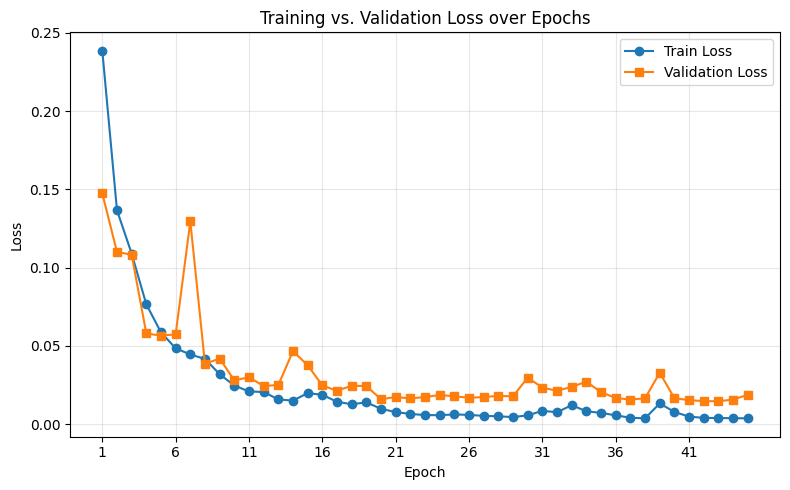
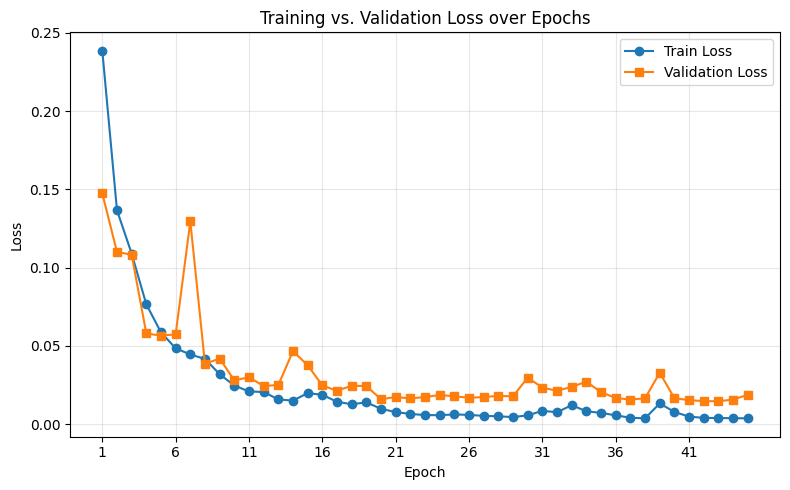

In [ ]:
import matplotlib.pyplot as plt

train_loss = [
    0.2385, 0.1367, 0.1090, 0.0766, 0.0587, 0.0485, 0.0446, 0.0417, 0.0320, 0.0247,
    0.0210, 0.0206, 0.0159, 0.0151, 0.0199, 0.0188, 0.0144, 0.0128, 0.0140, 0.0099,
    0.0078, 0.0066, 0.0059, 0.0058, 0.0063, 0.0060, 0.0054, 0.0051, 0.0046, 0.0057,
    0.0086, 0.0077, 0.0122, 0.0083, 0.0073, 0.0057, 0.0042, 0.0038, 0.0133, 0.0079,
    0.0049, 0.0041, 0.0040, 0.0039, 0.0038
]


val_loss = [
    .1474, 0.1100, 0.1083, 0.0580, 0.0566, 0.0574, 0.1295, 0.0386, 0.0420, 0.0280,
    0.0301, 0.0244, 0.0251, 0.0467, 0.0377, 0.0248, 0.0214, 0.0246, 0.0244, 0.0160,
    0.0174, 0.0165, 0.0174, 0.0187, 0.0179, 0.0169, 0.0174, 0.0181, 0.0179, 0.0298,
    0.0234, 0.0214, 0.0239, 0.0272, 0.0205, 0.0168, 0.0158, 0.0166, 0.0329, 0.0167,
    0.0154, 0.0148, 0.0147, 0.0158, 0.0188,
]


epochs = list(range(1, len(train_loss) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss,   marker='s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss over Epochs')
plt.xticks(epochs[::5])        # show every 5th epoch on the x-axis
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Some Prediction

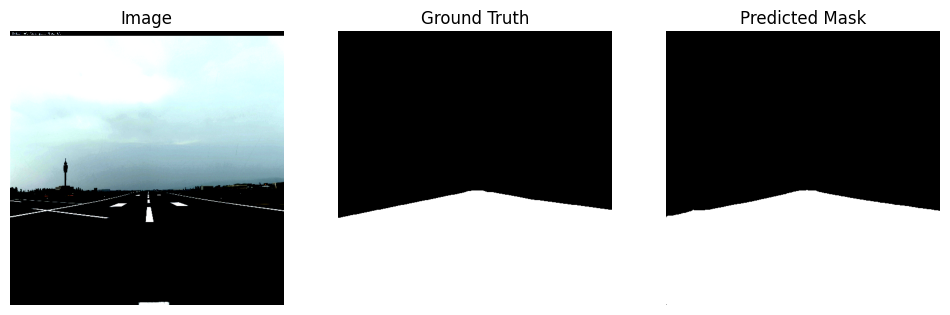

In [57]:
model.eval()
with torch.no_grad():
    imgs, lbls = next(iter(test_loader))
    imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
    preds = model(imgs).cpu()
    preds = torch.sigmoid(preds) > 0.5


img = imgs[0].cpu().permute(1, 2, 0).numpy()
lbl = lbls[0, 0].cpu().numpy()
pred = preds[0, 0].cpu().numpy()

# Visualize 
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(131); plt.imshow(img); plt.title("Image"); plt.axis('off')
plt.subplot(132); plt.imshow(lbl, cmap='gray'); plt.title("Ground Truth"); plt.axis('off')
plt.subplot(133); plt.imshow(pred, cmap='gray'); plt.title("Predicted Mask"); plt.axis('off')
plt.show()


In [29]:
import torch
import time

# 1) Move model to device and set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# 2) Prepare a dummy input (or one real batch) of the right size
#    e.g. batch_size=1, 3×H×W
dummy_input = torch.randn(1, 3, 256, 256, device=device)

# 3) Warm-up (laun-ch a few passes to stabilize the GPU)
with torch.no_grad():
    for _ in range(10):
        _ = model(dummy_input)

# 4) Actual timing with torch.cuda.Event
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

# Number of repeats to average over
n_runs = 100  
times = []

with torch.no_grad():
    for _ in range(n_runs):
        starter.record()           # start timing
        _ = model(dummy_input)     # inference
        ender.record()             # end timing
        # wait for GPU op to finish
        torch.cuda.synchronize()   
        times.append(starter.elapsed_time(ender))  # milliseconds

avg_ms = sum(times) / len(times)
print(f"Avg GPU inference time over {n_runs} runs: {avg_ms:.2f} ms")

# If you want throughput per second:
print(f"≈ {1000/avg_ms:.1f} images/sec")


Avg GPU inference time over 100 runs: 7.19 ms
≈ 139.1 images/sec


---
### **Inference TIME with Axial Unet = 7.19ms with Validation Loss = 0.0147 in 44 epoches** 
Avg GPU inference time over 100 runs: **7.19 ms**
≈ *139.1 images/sec*

---

## MobileViT-UNet Lite

In [94]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop=0.1):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p_drop),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p_drop),
        )
    def forward(self, x): return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )
    def forward(self, x): return self.pool_conv(x)


class Up(nn.Module):
   
    def __init__(self, x1_ch, x2_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(x1_ch, x1_ch, kernel_size=2, stride=2)
        self.conv = DoubleConv(x1_ch + x2_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
        # concat skip and conv
        return self.conv(torch.cat([x2, x1], dim=1))


class MobileViTBlock(nn.Module):
    def __init__(self, in_ch, transformer_dim=64, patch_size=4,
                 num_heads=4, num_layers=2, drop=0.1):
        super().__init__()
        self.local_rep = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True)
        )
        self.proj = nn.Conv2d(in_ch, transformer_dim, 1)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=transformer_dim,
            nhead=num_heads,
            dim_feedforward=transformer_dim*4,
            dropout=drop,
            activation='relu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.unproj = nn.Conv2d(transformer_dim, in_ch, 1)
        self.patch_size = patch_size
        self.dropout = nn.Dropout2d(drop)

    def forward(self, x):
        x_local = self.local_rep(x)
        B, C, H, W = x_local.shape
        x_proj = self.proj(x_local)
        p = self.patch_size
        # unfolding it into patches
        x_unfold = x_proj.unfold(2, p, p).unfold(3, p, p)
        B, D, Hp, Wp, _, _ = x_unfold.shape
        x_unfold = x_unfold.contiguous().view(B, D, Hp*Wp, p*p)
        x_seq = x_unfold.permute(0, 2, 3, 1).reshape(B*Hp*Wp, p*p, D)
        x_trans = self.transformer(x_seq)
        x_trans = x_trans.reshape(B, Hp*Wp, p*p, D).permute(0, 3, 1, 2)
        x_fold = x_trans.contiguous().view(B, D, Hp, Wp, p, p)
        x_fold = x_fold.permute(0, 1, 2, 4, 3, 5).reshape(B, D, Hp*p, Wp*p)
        x_unproj = self.unproj(x_fold)
        return x + self.dropout(x_unproj)


class MobileViTUNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.inc   = DoubleConv(3,   64)
        self.down1 = Down(64,  128)
        self.down2 = Down(128, 128)
        self.down3 = nn.Sequential(
            nn.MaxPool2d(2),
            MobileViTBlock(128, transformer_dim=64, patch_size=4,
                           num_heads=4, num_layers=2, drop=0.1)
        )
        self.down4 = Down(128, 256)

        self.up1 = Up(256, 128, 128)   
        self.up2 = Up(128, 128,  64)   
        self.up3 = Up(64,  128,  32)   

        self.outc = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        orig_size = x.shape[2:]
        x1 = self.inc(x)       
        x2 = self.down1(x1)    
        x3 = self.down2(x2)    
        x4 = self.down3(x3)    
        x5 = self.down4(x4)    

        u1 = self.up1(x5, x4)  
        u2 = self.up2(u1, x3)
        u3 = self.up3(u2, x2)  

        logits = self.outc(u3)           
        return F.interpolate(logits, size=orig_size,
                             mode='bilinear', align_corners=True)

model = MobileViTUNet(num_classes=1)
model = model.to(config.DEVICE)

In [ ]:


criterion = nn.BCEWithLogitsLoss()  # loss function that combines a sigmoid activation and the binary cross-entropy (BCE) loss in a single function best for binary classification
optimizer = optim.Adam(model.parameters(), lr=5e-4)
ACCUMULATION_STEPS = 8

def train_epoch(loader):
    model.train()
    running_loss = 0
    optimizer.zero_grad()

    loop = tqdm(enumerate(loader), total=len(loader), desc=f"Train Epoch {epoch}")
    for step, (imgs, lbls) in loop:
        imgs.shape
        imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
        preds = model(imgs)
        loss = (criterion(preds, lbls)) / ACCUMULATION_STEPS  # scale loss

        loss.backward()
        running_loss += loss.item() * ACCUMULATION_STEPS  # un‐scale for logging

        # gradient step once every ACCUMULATION_STEPS
        if (step + 1) % ACCUMULATION_STEPS == 0 or (step + 1) == len(loader):
            optimizer.step()
            optimizer.zero_grad()

        loop.set_postfix({
            "batch_loss": f"{running_loss / (step + 1):.4f}"
        })

    avg_loss = running_loss / len(loader)
    return avg_loss



def eval_epoch(loader, epoch):
    model.eval()
    running_loss = 0.0

    loop = tqdm(enumerate(loader), total=len(loader), desc=f"Eval  Epoch {epoch}", colour="green")
    with torch.no_grad():
        for step, (imgs, lbls) in loop:
            imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
            preds = model(imgs)
            loss = criterion(preds, lbls)

            running_loss += loss.item()
            loop.set_postfix({
                "batch_loss": f"{running_loss / (step + 1):.4f}"
            })

    avg_loss = running_loss / len(loader)
    return avg_loss

In [ ]:
EPOCHS = 50

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(train_loader)
    val_loss = eval_epoch(test_loader, epoch)
    print(f"Epoch {epoch}/{EPOCHS} — train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")

    # Save model
    torch.save(model.state_dict(), f"MobileViTUNet{epoch}.pth")


In [ ]:
def load_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE)
    model.load_state_dict(checkpoint)
    print(f"Checkpoint loaded. Resuming training from epoch {49}")
    
load_checkpoint(model, '/kaggle/working/MobileViTUNet19.pth')

In [93]:
torch.cuda.empty_cache()

In [ ]:
import torch
import time

# 1) Move model to device and set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# 2) Prepare a dummy input (or one real batch) of the right size
#    e.g. batch_size=1, 3×H×W
dummy_input = torch.randn(1, 3, 256, 256, device=device)

# 3) Warm-up (laun-ch a few passes to stabilize the GPU)
with torch.no_grad():
    for _ in range(10):
        _ = model(dummy_input)

# 4) Actual timing with torch.cuda.Event
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

# Number of repeats to average over
n_runs = 100  
times = []

with torch.no_grad():
    for _ in range(n_runs):
        starter.record()           # start timing
        _ = model(dummy_input)     # inference
        ender.record()             # end timing
        # wait for GPU op to finish
        torch.cuda.synchronize()   
        times.append(starter.elapsed_time(ender))  # milliseconds

avg_ms = sum(times) / len(times)
print(f"Avg GPU inference time over {n_runs} runs: {avg_ms:.2f} ms")

# If you want throughput per second:
print(f"≈ {1000/avg_ms:.1f} images/sec")


---
### **Inference TIME with MobileViT-UNet Lite  = 3.79ms with Validation Loss = 0.0183 in 61 epoches** 
Avg GPU inference time over 100 runs: **3.79 ms**
≈ *264.1 images/sec*

---

## MobileViT-UNet 

In [84]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop=0.05):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p_drop),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p_drop),
        )
    def forward(self, x): return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )
    def forward(self, x): return self.pool_conv(x)

class Up(nn.Module):
    def __init__(self, x1_ch, x2_ch, out_ch):
        super().__init__()
        self.up   = nn.ConvTranspose2d(x1_ch, x1_ch, 2, stride=2)
        self.conv = DoubleConv(x1_ch + x2_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        dy, dx = x2.size(2) - x1.size(2), x2.size(3) - x1.size(3)
        x1 = F.pad(x1, [dx//2, dx-dx//2, dy//2, dy-dy//2])
        return self.conv(torch.cat([x2, x1], dim=1))


class MobileViTBlock(nn.Module):
    def __init__(self, in_ch, transformer_dim=96, patch_size=4,
                 num_heads=4, num_layers=3, drop=0.05):
        super().__init__()
        self.local = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True)
        )
        self.proj = nn.Conv2d(in_ch, transformer_dim, 1)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=transformer_dim,
            nhead=num_heads,
            dim_feedforward=transformer_dim*4,
            dropout=drop,
            activation='relu',
            batch_first=True,
            norm_first=True
        )
        self.trans = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.unproj = nn.Conv2d(transformer_dim, in_ch, 1)
        self.ps = patch_size
        self.drop = nn.Dropout2d(drop)

    def forward(self, x):
        xl = self.local(x)      # B×C×H×W
        B,C,H,W = xl.shape
        xp = self.proj(xl)      # B×D×H×W
        p  = self.ps
        uf = xp.unfold(2,p,p).unfold(3,p,p)    # B×D×Hp×Wp×p×p
        B,D,Hp,Wp,_,_ = uf.shape
        uf = uf.contiguous().view(B, D, Hp*Wp, p*p)
        seq= uf.permute(0,2,3,1).reshape(B*Hp*Wp, p*p, D)
        tr = self.trans(seq)    # (B*Hp*Wp)×(p*p)×D
        tf = tr.reshape(B,Hp*Wp,p*p,D).permute(0,3,1,2)
        fd = tf.contiguous().view(B, D, Hp, Wp, p, p)
        fd = fd.permute(0,1,2,4,3,5).reshape(B, D, Hp*p, Wp*p)
        xu = self.unproj(fd)
        return x + self.drop(xu)


class MobileViTUNetM(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        # Wider initial convs
        self.inc   = DoubleConv(3,   96)
        self.down1 = Down(96,  160)
        # Inject ViT at two scales
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            MobileViTBlock(160, transformer_dim=96, patch_size=4,
                           num_heads=4, num_layers=3, drop=0.05)
        )
        self.down3 = Down(160, 256)
        self.down4 = nn.Sequential(
            nn.MaxPool2d(2),
            MobileViTBlock(256, transformer_dim=128, patch_size=4,
                           num_heads=4, num_layers=2, drop=0.05)
        )
        self.down5 = Down(256, 512)

        self.up1 = Up(512, 256, 256)   # x6 (512) + x5 (256) → 256
        self.up2 = Up(256, 256, 160)   # u1 (256) + x4 (256) → 160
        self.up3 = Up(160, 160,  96)   # u2 (160) + x3 (160) →  96
        self.up4 = Up(96,  160,  48)   # u3 (96)  + x2 (160) →  48

        self.outc = nn.Conv2d(48, num_classes, kernel_size=1)

    def forward(self, x):
        orig = x.shape[2:]
        x1 = self.inc(x)    # 96×512×512
        x2 = self.down1(x1) # 160×256×256
        x3 = self.down2(x2) # 160×128×128 (ViT)
        x4 = self.down3(x3) # 256×64×64
        x5 = self.down4(x4) # 256×32×32 (ViT)
        x6 = self.down5(x5) # 512×16×16

        u1 = self.up1(x6, x5)  # 256×32×32
        u2 = self.up2(u1, x4)  # 160×64×64
        u3 = self.up3(u2, x3)  # 96×128×128
        u4 = self.up4(u3, x2)  # 48×256×256

        logits = self.outc(u4)                  # 1×256×256
        return F.interpolate(logits, size=orig,
                             mode='bilinear',
                             align_corners=True)

# instantiate
model = MobileViTUNetM(num_classes=1).to(config.DEVICE)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [85]:
sum(p.numel() for p in model.parameters())

11876721

In [34]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

criterion = nn.BCEWithLogitsLoss()  # loss function that combines a sigmoid activation and the binary cross-entropy (BCE) loss in a single function best for binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)
ACCUMULATION_STEPS = 8

def train_epoch(loader):
    model.train()
    running_loss = 0
    optimizer.zero_grad()

    loop = tqdm(enumerate(loader), total=len(loader), desc=f"Train Epoch {epoch}")
    for step, (imgs, lbls) in loop:
        imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
        preds = model(imgs)
        loss = criterion(preds, lbls) / ACCUMULATION_STEPS  # scale loss

        loss.backward()
        running_loss += loss.item() * ACCUMULATION_STEPS  # un‐scale for logging

        # gradient step once every ACCUMULATION_STEPS
        if (step + 1) % ACCUMULATION_STEPS == 0 or (step + 1) == len(loader):
            optimizer.step()
            optimizer.zero_grad()

        loop.set_postfix({
            "batch_loss": f"{running_loss / (step + 1):.4f}"
        })

    avg_loss = running_loss / len(loader)
    return avg_loss



def eval_epoch(loader, epoch):
    model.eval()
    running_loss = 0.0

    loop = tqdm(enumerate(loader), total=len(loader), desc=f"Eval  Epoch {epoch}", colour="green")
    with torch.no_grad():
        for step, (imgs, lbls) in loop:
            imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
            preds = model(imgs)
            loss = criterion(preds, lbls)

            running_loss += loss.item()
            loop.set_postfix({
                "batch_loss": f"{running_loss / (step + 1):.4f}"
            })

    avg_loss = running_loss / len(loader)
    return avg_loss

In [ ]:
EPOCHS = 50

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(train_loader)
    val_loss = eval_epoch(test_loader, epoch)
    print(f"Epoch {epoch}/{EPOCHS} — train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")

    # Save model
    torch.save(model.state_dict(), f"hybrid_Unet_transformer{epoch}.pth")


In [83]:
torch.cuda.empty_cache()

In [86]:
def load_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE)
    model.load_state_dict(checkpoint)
    print(f"Checkpoint loaded. Resuming training from epoch {1}")
    
load_checkpoint(model, '/kaggle/working/hybrid_Unet_transformer1.pth')

Checkpoint loaded. Resuming training from epoch 1


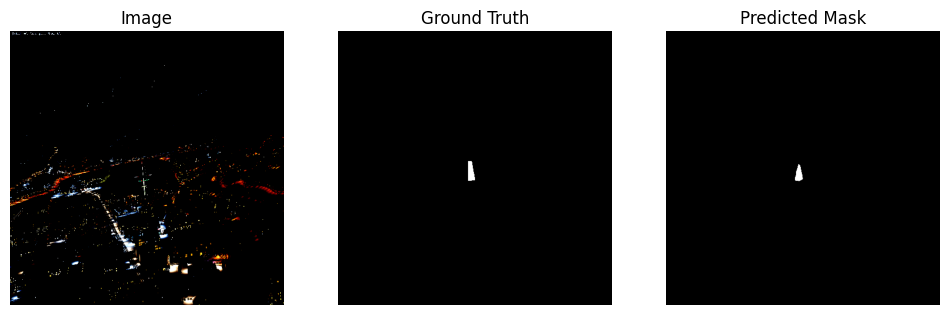

In [90]:
model.eval()
with torch.no_grad():
    imgs, lbls = next(iter(test_loader))
    imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)
    preds = model(imgs).cpu()
    preds = torch.sigmoid(preds) > 0.5


img = imgs[7].cpu().permute(1, 2, 0).numpy()
lbl = lbls[7, 0].cpu().numpy()
pred = preds[7, 0].cpu().numpy()

# Visualize 
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(131); plt.imshow(img); plt.title("Image"); plt.axis('off')
plt.subplot(132); plt.imshow(lbl, cmap='gray'); plt.title("Ground Truth"); plt.axis('off')
plt.subplot(133); plt.imshow(pred, cmap='gray'); plt.title("Predicted Mask"); plt.axis('off')
plt.show()


In [92]:
import torch
import time

# 1) Move model to device and set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# 2) Prepare a dummy input (or one real batch) of the right size
#    e.g. batch_size=1, 3×H×W
dummy_input = torch.randn(1, 3, 256, 256, device=device)

# 3) Warm-up (laun-ch a few passes to stabilize the GPU)
with torch.no_grad():
    for _ in range(10):
        _ = model(dummy_input)

# 4) Actual timing with torch.cuda.Event
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

# Number of repeats to average over
n_runs = 100  
times = []

with torch.no_grad():
    for _ in range(n_runs):
        starter.record()           # start timing
        _ = model(dummy_input)     # inference
        ender.record()             # end timing
        # wait for GPU op to finish
        torch.cuda.synchronize()   
        times.append(starter.elapsed_time(ender))  # milliseconds

avg_ms = sum(times) / len(times)
print(f"Avg GPU inference time over {n_runs} runs: {avg_ms:.2f} ms")

# If you want throughput per second:
print(f"≈ {1000/avg_ms:.1f} images/sec")


Avg GPU inference time over 100 runs: 7.74 ms
≈ 129.3 images/sec


In [ ]:
Train Epoch 1: 100%|██████████| 349/349 [04:11<00:00,  1.39it/s, batch_loss=0.3450]
Eval  Epoch 1: 100%|██████████| 150/150 [00:49<00:00,  3.03it/s, batch_loss=0.2137]
Epoch 1/50 — train_loss: 0.3450, val_loss: 0.2137
Train Epoch 2: 100%|██████████| 349/349 [04:11<00:00,  1.39it/s, batch_loss=0.1938]
Eval  Epoch 2: 100%|██████████| 150/150 [00:38<00:00,  3.92it/s, batch_loss=0.1566]
Epoch 2/50 — train_loss: 0.1938, val_loss: 0.1566
Train Epoch 3: 100%|██████████| 349/349 [04:11<00:00,  1.39it/s, batch_loss=0.1496]
Eval  Epoch 3: 100%|██████████| 150/150 [00:38<00:00,  3.91it/s, batch_loss=0.1218]
Epoch 3/50 — train_loss: 0.1496, val_loss: 0.1218
Train Epoch 4: 100%|██████████| 349/349 [04:11<00:00,  1.39it/s, batch_loss=0.1205]
Eval  Epoch 4: 100%|██████████| 150/150 [00:37<00:00,  3.97it/s, batch_loss=0.1134]
Epoch 4/50 — train_loss: 0.1205, val_loss: 0.1134
Train Epoch 5: 100%|██████████| 349/349 [04:11<00:00,  1.39it/s, batch_loss=0.1089]
Eval  Epoch 5: 100%|██████████| 150/150 [00:37<00:00,  3.95it/s, batch_loss=0.1735]
Epoch 5/50 — train_loss: 0.1089, val_loss: 0.1735
Train Epoch 7: 100%|██████████| 349/349 [04:11<00:00,  1.39it/s, batch_loss=0.0900]
Eval  Epoch 7: 100%|██████████| 150/150 [00:37<00:00,  3.95it/s, batch_loss=0.0709]
Epoch 7/50 — train_loss: 0.0900, val_loss: 0.0709
Train Epoch 8: 100%|██████████| 349/349 [04:11<00:00,  1.39it/s, batch_loss=0.0756]
Eval  Epoch 8: 100%|██████████| 150/150 [00:38<00:00,  3.94it/s, batch_loss=0.0592]
Epoch 8/50 — train_loss: 0.0756, val_loss: 0.0592
Train Epoch 9: 100%|██████████| 349/349 [04:11<00:00,  1.39it/s, batch_loss=0.0683]
Eval  Epoch 9: 100%|██████████| 150/150 [00:37<00:00,  3.98it/s, batch_loss=0.0641]
Epoch 9/50 — train_loss: 0.0683, val_loss: 0.0641
Train Epoch 10: 100%|██████████| 349/349 [04:11<00:00,  1.39it/s, batch_loss=0.0661]
Eval  Epoch 10: 100%|██████████| 150/150 [00:38<00:00,  3.94it/s, batch_loss=0.0690]
Epoch 10/50 — train_loss: 0.0661, val_loss: 0.0690
Train Epoch 11: 100%|██████████| 349/349 [04:11<00:00,  1.39it/s, batch_loss=0.0583]
Eval  Epoch 11: 100%|██████████| 150/150 [00:37<00:00,  3.96it/s, batch_loss=0.0488]
Epoch 11/50 — train_loss: 0.0583, val_loss: 0.0488
Train Epoch 12:  84%|████████▍ | 294/349 [03:31<00:39,  1.40it/s, batch_loss=0.0563]
Train Epoch 1: 100%|██████████| 349/349 [04:11<00:00,  1.39it/s, batch_loss=0.0450]
Eval  Epoch 1: 100%|██████████| 150/150 [00:38<00:00,  3.87it/s, batch_loss=0.0430]
Epoch 1/50 — train_loss: 0.0450, val_loss: 0.0430
Train Epoch 2: 100%|██████████| 349/349 [04:10<00:00,  1.39it/s, batch_loss=0.0382]
Eval  Epoch 2: 100%|██████████| 150/150 [00:37<00:00,  3.96it/s, batch_loss=0.0383]
Epoch 2/50 — train_loss: 0.0382, val_loss: 0.0383
Train Epoch 3: 100%|██████████| 349/349 [04:10<00:00,  1.39it/s, batch_loss=0.0362]
Eval  Epoch 3: 100%|██████████| 150/150 [00:37<00:00,  3.96it/s, batch_loss=0.0393]
Epoch 3/50 — train_loss: 0.0362, val_loss: 0.0393
Train Epoch 4: 100%|██████████| 349/349 [04:10<00:00,  1.39it/s, batch_loss=0.0321]
Eval  Epoch 4: 100%|██████████| 150/150 [00:38<00:00,  3.92it/s, batch_loss=0.0331]
Epoch 4/50 — train_loss: 0.0321, val_loss: 0.0331
Train Epoch 5: 100%|██████████| 349/349 [04:10<00:00,  1.39it/s, batch_loss=0.0295]
Eval  Epoch 5: 100%|██████████| 150/150 [00:37<00:00,  3.97it/s, batch_loss=0.0391]
Epoch 5/50 — train_loss: 0.0295, val_loss: 0.0391
Train Epoch 6:  97%|█████████▋| 337/349 [04:02<00:08,  1.39it/s, batch_loss=0.0326
Train Epoch 1: 100%|██████████| 349/349 [04:10<00:00,  1.39it/s, batch_loss=0.0141]
Eval  Epoch 1: 100%|██████████| 150/150 [00:37<00:00,  3.98it/s, batch_loss=0.0262]
Epoch 1/50 — train_loss: 0.0141, val_loss: 0.0262
Train Epoch 2: 100%|██████████| 349/349 [04:11<00:00,  1.39it/s, batch_loss=0.0110]
Eval  Epoch 2: 100%|██████████| 150/150 [00:37<00:00,  3.96it/s, batch_loss=0.0259]
Epoch 2/50 — train_loss: 0.0110, val_loss: 0.0259
Train Epoch 3: 100%|██████████| 349/349 [04:11<00:00,  1.39it/s, batch_loss=0.0136]
Eval  Epoch 3: 100%|██████████| 150/150 [00:38<00:00,  3.94it/s, batch_loss=0.0220]
Epoch 3/50 — train_loss: 0.0136, val_loss: 0.0220
Train Epoch 4: 100%|██████████| 349/349 [04:11<00:00,  1.39it/s, batch_loss=0.0121]
Eval  Epoch 4: 100%|██████████| 150/150 [00:37<00:00,  3.95it/s, batch_loss=0.0224]
Epoch 4/50 — train_loss: 0.0121, val_loss: 0.0224
Train Epoch 5: 100%|██████████| 349/349 [04:11<00:00,  1.39it/s, batch_loss=0.0142]
Eval  Epoch 5: 100%|██████████| 150/150 [00:38<00:00,  3.92it/s, batch_loss=0.0243]
Epoch 5/50 — train_loss: 0.0142, val_loss: 0.0243

---
### **Inference TIME with MobileViT-UNet  = 7.74s with Validation Loss = 0.0125 in 52 epoches** 
Avg GPU inference time over 100 runs: **7.74 ms**
≈ *129.3 images/sec*

---

In [30]:
imgs, lbls = next(iter(test_loader))
imgs, lbls = imgs.to(config.DEVICE), lbls.to(config.DEVICE)

In [33]:
imgs.shape, lbls.shape

(torch.Size([32, 3, 512, 512]), torch.Size([32, 1, 512, 512]))

In [ ]:
lbls